# Import

In [ ]:
import subprocess
import json
import pickle

DEFAULT_ATTRIBUTES = (
    'index',
    'uuid',
    'name',
    'timestamp',
    'memory.total',
    'memory.free',
    'memory.used',
    'utilization.gpu',
    'utilization.memory'
)

def get_gpu_info(nvidia_smi_path='nvidia-smi', keys=DEFAULT_ATTRIBUTES, no_units=True):
    nu_opt = '' if not no_units else ',nounits'
    cmd = '%s --query-gpu=%s --format=csv,noheader%s' % (nvidia_smi_path, ','.join(keys), nu_opt)
    output = subprocess.check_output(cmd, shell=True)
    lines = output.decode().split('\n')
    lines = [ line.strip() for line in lines if line.strip() != '' ]

    return [ { k: v for k, v in zip(keys, line.split(', ')) } for line in lines ]


import pprint
pprint.pprint(get_gpu_info())

[{'index': '0',
  'memory.free': '16160',
  'memory.total': '16160',
  'memory.used': '0',
  'name': 'Tesla V100-SXM2-16GB',
  'timestamp': '2021/02/14 01:57:15.701',
  'utilization.gpu': '0',
  'utilization.memory': '0',
  'uuid': 'GPU-419b2a37-5033-f671-8d48-762ff3b6436f'}]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/kaggle/kaggle-bird

/content/drive/My Drive/kaggle/kaggle-bird


In [ ]:
!pip -q install --upgrade pip
!pip -q install timm
!pip -q install torchlibrosa
!pip -q install audiomentations
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

     |████████████████████████████████| 1.5MB 13.0MB/s 
     |████████████████████████████████| 244 kB 13.3 MB/s 


In [ ]:
!pip install microsoftvision
!pip install soundfile
!pip install transformers

     |████████████████████████████████| 339 kB 12.4 MB/s 
     |████████████████████████████████| 103 kB 22.8 MB/s 
     |████████████████████████████████| 3.2 MB 22.0 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 127 kB 96.9 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 13.5 MB/s 
     |████████████████████████████████| 3.2 MB 80.1 MB/s 
     |████████████████████████████████| 883 kB 91.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=984a53b0658984811342c39f1dce98011799c2784f444676d071965af94095d1
  Stored in directory: /root/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr

In [ ]:
import os, glob, random, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from functools import partial
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from transformers import get_linear_schedule_with_warmup
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import timm
from timm.models.efficientnet import tf_efficientnet_b0_ns

import torchvision.models as models

# MODEL

In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()

def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))

def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


In [ ]:
class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

# Create Folds

In [ ]:
train_moto = pd.read_csv("/content/drive/My Drive/kaggle/kaggle-bird/mluti_label_train_df.csv")
train_moto

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,d49a94504_01,"0,18",1,0,5000,5.2,10000
1,97630c03d_03,"0,18,3",1,0,5000,5.2,10000
2,97630c03d_02,"0,18,3",1,0,5000,5.2,10000
3,d9bfc9e6b_02,"0,1,3,12",1,0,5000,5.2,10000
4,3710abba6_02,"0,18",1,0,5000,5.2,10000
...,...,...,...,...,...,...,...
2423,59a9eb657_02,"23,3,12",1,0,5000,5.2,10000
2424,6c032e356_01,"23,12",1,0,5000,5.2,10000
2425,006ab765f_05,"23,3",1,0,5000,5.2,10000
2426,79f38de91_02,23,1,0,5000,5.2,10000


In [ ]:
FOLDS = 5
SEED = 42

train = pd.read_csv("/content/drive/My Drive/kaggle/kaggle-bird/mluti_label_train_df.csv")#.sort_values("recording_id")
ss = pd.read_csv("/content/drive/My Drive/kaggle/kaggle-bird/sample_submission.csv")

In [ ]:
train

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,d49a94504_01,"0,18",1,0,5000,5.2,10000
1,97630c03d_03,"0,18,3",1,0,5000,5.2,10000
2,97630c03d_02,"0,18,3",1,0,5000,5.2,10000
3,d9bfc9e6b_02,"0,1,3,12",1,0,5000,5.2,10000
4,3710abba6_02,"0,18",1,0,5000,5.2,10000
...,...,...,...,...,...,...,...
2423,59a9eb657_02,"23,3,12",1,0,5000,5.2,10000
2424,6c032e356_01,"23,12",1,0,5000,5.2,10000
2425,006ab765f_05,"23,3",1,0,5000,5.2,10000
2426,79f38de91_02,23,1,0,5000,5.2,10000


In [ ]:
species_id_count = []
for i in train['species_id'].to_list():
    species_id = i.split(',')
    species_id_count.append(np.array(species_id))

In [ ]:
species_id_all = np.concatenate(np.array(species_id_count), axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
species_id_all_df = pd.DataFrame(species_id_all)

In [ ]:
species_id_all_df.value_counts()

3     1257
12     520
18     512
7      357
1      314
23     260
11     249
21     243
15     235
4      204
8      164
0      157
20     133
2      129
22     126
14     125
10     120
5      118
19     110
9      109
13     107
16     100
17     100
6       97
dtype: int64

In [ ]:
species_id_all_df.value_counts()

3     1257
12     520
18     512
7      357
1      314
23     260
11     249
21     243
15     235
4      204
8      164
0      157
20     133
2      129
22     126
14     125
10     120
5      118
19     110
9      109
13     107
16     100
17     100
6       97
dtype: int64

In [ ]:
all_labels = []
for index,row in train.iterrows():
  species_ids = row['species_id'].split(',')
  label = np.zeros(24, dtype=np.int64)
  for i in species_ids:
    i = int(i)
    label[i] = 1
  # label = np.append(label,row['recording_id'])
  all_labels.append(label)
  # print(row['recording_id'])
  # print(label)

In [ ]:
new_y = np.array(all_labels)

In [ ]:
new_y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# new_X = np.array(train['recording_id'])
new_X = np.array(train.index)

In [ ]:
new_X

array([   0,    1,    2, ..., 2425, 2426, 2427])

In [ ]:
# !pip install iterative-stratification

In [ ]:
#get data
train['kfold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=FOLDS, random_state=SEED)
for i, (_, test_index) in enumerate(mskf.split(new_X, new_y)):
    train.iloc[test_index, -1] = i
    
train['kfold'] = train['kfold'].astype('int')

train.to_csv("train_all.csv", index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
train

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,kfold
0,d49a94504_01,"0,18",1,0,5000,5.2,10000,2
1,97630c03d_03,"0,18,3",1,0,5000,5.2,10000,1
2,97630c03d_02,"0,18,3",1,0,5000,5.2,10000,2
3,d9bfc9e6b_02,"0,1,3,12",1,0,5000,5.2,10000,1
4,3710abba6_02,"0,18",1,0,5000,5.2,10000,2
...,...,...,...,...,...,...,...,...
2423,59a9eb657_02,"23,3,12",1,0,5000,5.2,10000,3
2424,6c032e356_01,"23,12",1,0,5000,5.2,10000,4
2425,006ab765f_05,"23,3",1,0,5000,5.2,10000,0
2426,79f38de91_02,23,1,0,5000,5.2,10000,4


In [ ]:
train_fold = train[train['kfold']==2]

In [ ]:
species_id_count = []
for i in train_fold['species_id'].to_list():
    species_id = i.split(',')
    species_id_count.append(np.array(species_id))

In [ ]:
species_id_all = np.concatenate(np.array(species_id_count), axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
species_id_all_df = pd.DataFrame(species_id_all)

In [ ]:
#fold2 #確認
species_id_all_df.value_counts()

3     251
12    104
18    102
7      72
1      63
23     52
11     50
21     48
15     47
4      41
8      33
0      31
20     27
2      26
22     25
14     25
10     24
5      24
9      22
13     22
19     22
16     20
17     20
6      19
dtype: int64

In [ ]:
import microsoftvision
from torchvision import transforms
import torch
from PIL import Image

def get_image():
    img = cv2.imread('example.jpg', cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img[16:256-16, 16:256-16]
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0) # Unsqueeze only required when there's 1 image in images batch

In [ ]:
class PANNsDense161Att(nn.Module):
    def __init__(self, sample_rate: int, window_size: int, hop_size: int,
                 mel_bins: int, fmin: int, fmax: int, classes_num: int, apply_aug: bool, top_db=None):
        super().__init__()
        
        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        self.interpolate_ratio = 30  # Downsampled ratio
        self.apply_aug = apply_aug

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(
            sr=sample_rate,
            n_fft=window_size,
            n_mels=mel_bins,
            fmin=fmin,
            fmax=fmax,
            ref=ref,
            amin=amin,
            top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64,
            time_stripes_num=2,
            freq_drop_width=8,
            freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)

        self.fc1 = nn.Linear(2048,1024, bias=True)#<======2208,1024,512=0.943
        self.att_block = AttBlock(1024, classes_num, activation='linear')#<===========sigmoid

        self.init_weight()

        # self.densenet_features = models.densenet161(pretrained=True).features
        # This will load pretrained model
        self.model = microsoftvision.models.resnet50(pretrained=True)
        self.densenet_features = nn.Sequential(*list(self.model.children())[:-1])

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        
    def cnn_feature_extractor(self, x):
        x = self.densenet_features(x)
        return x
    
    def preprocess(self, input_x, mixup_lambda=None):

        x = self.spectrogram_extractor(input_x)  # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training and self.apply_aug:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training  and self.apply_aug and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        return x, frames_num
        

    def forward(self, input_data):
        x = self.spectrogram_extractor(input_data)
        # batch_size x 1 x time_steps x freq_bins
        x = self.logmel_extractor(x)
        # batch_size x 1 x time_steps x mel_bins
        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        # Output shape (batch size, channels, time, frequency)
        x = x.expand(x.shape[0], 3, x.shape[2], x.shape[3])
        x = self.cnn_feature_extractor(x)
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output' : framewise_output,
            'logit' : logit,
            'clipwise_output' : clipwise_output
        }

        return output_dict


# Dataset

In [ ]:
def crop_or_pad(y, sr, period, record, mode="train"):
    len_y = len(y)
    effective_length = sr * period
    rint = np.random.randint(len(record['t_min']))
    time_start = record['t_min'][rint] * sr
    time_end = record['t_max'][rint] * sr
    if len_y > effective_length:
        # Positioning sound slice
        center = np.round((time_start + time_end) / 2)
        beginning = center - effective_length / 2
        if beginning < 0:
            beginning = 0
        beginning = np.random.randint(beginning, center)
        ending = beginning + effective_length
        if ending > len_y:
            ending = len_y
        beginning = ending - effective_length
        y = y[beginning:ending].astype(np.float32)
    else:
        y = y.astype(np.float32)
        beginning = 0
        ending = effective_length


    beginning_time = beginning / sr
    ending_time = ending / sr
    label = np.zeros(24, dtype='f')

    for i in range(len(record['t_min'])):
        if (record['t_min'][i] <= ending_time) and (record['t_max'][i] >= beginning_time):
            label[record['species_id'][i]] = 1
    
    return y, label

In [ ]:
class SedDataset:
    def __init__(self, df, period=5, stride=5, audio_transform=None, data_path="train", mode="train"):

        self.period = period
        self.stride = stride
        self.audio_transform = audio_transform
        self.data_path = data_path
        self.mode = mode

        self.df = df.groupby("recording_id").agg(lambda x: list(x)).reset_index()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]

        y, sr = sf.read(f"{self.data_path}/{record['recording_id']}.wav")#flac
        
        if self.mode != "test":
            effective_length = self.period * sr
            y = y[0:effective_length].astype(np.float32)
            label = np.zeros(24, dtype='f')

            # y, label = crop_or_pad(y, sr, period=self.period, record=record, mode=self.mode)

            if self.audio_transform:
                y = self.audio_transform(samples=y, sample_rate=sr)
            species_ids = record['species_id'][0].split(',') 
            for i in species_ids:
                i = int(i)
                label[i] = 1

        else:#<=====test
            y_ = []
            i = 0
            #sr = 48000
            #period = 10s
            effective_length = self.period * sr
            #effective_length 480000
            stride = self.stride * sr#self.stride = 5sづつ10sがスライドする
            #stride 240000
            y = np.stack([y[i:i+effective_length].astype(np.float32) for i in range(0, 60*sr+stride-effective_length, stride)])#range(0,60*48000+240000-480000,240000)
            # print(y.shape)
      
            #いらない
            label = np.zeros(24, dtype='f')
            if self.mode == "valid":
                species_ids = record['species_id'][0].split(',') 
                for i in species_ids:
                    i = int(i)
                    label[i] = 1

        return {
            "image" : y,
            "target" : label,
            "id" : record['recording_id']
        }

# Augmentations

In [ ]:
import audiomentations as AA

train_audio_transform = AA.Compose([
    AA.AddGaussianNoise(p=0.5),
    AA.AddGaussianSNR(p=0.5),
    #AA.AddBackgroundNoise("../input/train_audio/", p=1)
    #AA.AddImpulseResponse(p=0.1),
    #AA.AddShortNoises("../input/train_audio/", p=1)
    AA.FrequencyMask(min_frequency_band=0.0,  max_frequency_band=0.2, p=0.3),
    AA.TimeMask(min_band_part=0.0, max_band_part=0.2, p=0.8),
    AA.PitchShift(min_semitones=-0.5, max_semitones=0.5, p=0.1),
    AA.Shift(p=0.1),
    #AA.Normalize(p=0.1),
    #AA.ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=1, p=0.05),
    #AA.PolarityInversion(p=0.05),
    AA.Gain(p=0.2)
])

# Utils

In [ ]:
def _lwlrap_sklearn(truth, scores):
    """Reference implementation from https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8"""
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = metrics.label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MetricMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
    
    def update(self, y_true, y_pred):
        self.y_true.extend(y_true.cpu().detach().numpy().tolist())
        self.y_pred.extend(y_pred.cpu().detach().numpy().tolist())

    @property
    def avg(self):
        #score_class, weight = lwlrap(np.array(self.y_true), np.array(self.y_pred))
        self.score = _lwlrap_sklearn(np.array(self.y_true), np.array(self.y_pred)) #(score_class * weight).sum()
        return {
            "lwlrap" : self.score
        }

def seed_everithing(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# Losses

In [ ]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        # self.bce = nn.BCELoss()
        self.bce = nn.BCEWithLogitsLoss(pos_weight = pos_weight)#pos_weight = pos_weight

    def forward(self, input, target):
        # input_ = input["framewise_output"]
        input_ = input["logit"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

In [ ]:
class ImprovedPANNsLoss(nn.Module):
    def __init__(self, output_key="logit", weights=[1, 0.5]):
        super().__init__()

        self.output_key = output_key
        if output_key == "logit":
            self.normal_loss = nn.BCEWithLogitsLoss()
        else:
            self.normal_loss = nn.BCELoss()

        self.bce = nn.BCELoss()
        self.weights = weights

    def forward(self, input, target):
        input_ = input[self.output_key]
        target = target.float()#torch.Size([16, 24])

        framewise_output = input["framewise_output"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)#torch.Size([16, 24])
        normal_loss = self.normal_loss(input_, target)
        # print('normal_loss',normal_loss)


        # clipwise_output_with_max = torch.where(torch.isnan(clipwise_output_with_max),
        #                      torch.zeros_like(clipwise_output_with_max),
        #                      clipwise_output_with_max)
        # clipwise_output_with_max = torch.where(torch.isinf(clipwise_output_with_max),
        #                      torch.zeros_like(clipwise_output_with_max),
        #                      clipwise_output_with_max)
        # target = target.float()

        # auxiliary_loss = self.bce(clipwise_output_with_max, target)
        # print('auxiliary_loss',auxiliary_loss)
        return normal_loss #self.weights[0] * normal_loss + self.weights[1] * auxiliary_loss

In [ ]:
class FocalLoss(nn.Module):
  def __init__(self):
        super().__init__()
        # self.bce = nn.BCEWithLogitsLoss()
        self.alpha = 0.25
        self.gamma = 2.5

  def forward(self, input, target): 
    # preds = input["logit"]#<====================
    preds = input["framewise_output"]
    preds,_ = preds.max(dim=1)#torch.Size([16, 24])
    

    # preds = torch.where(torch.isnan(preds),
    #                          torch.zeros_like(preds),
    #                          preds)
    # preds = torch.where(torch.isinf(preds),
    #                          torch.zeros_like(preds),
    #                          preds)


    

    targets = target.float()#torch.Size([16, 24])

    loss_fct = nn.BCEWithLogitsLoss(reduction='none')
    bce_loss = loss_fct(preds, targets)
    probas = torch.sigmoid(preds)
    loss = torch.where(targets >= 0.5, self.alpha * (1. - probas)**self.gamma * bce_loss, probas**self.gamma * bce_loss)
    loss = loss.mean()
    return loss

In [ ]:
class FocalLoss_(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ############
        input = input["framewise_output"]
        input,_ = input.max(dim=1)#torch.Size([16, 24])
        ############
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
               ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss

        return loss.sum(dim=1).mean()
    
class FbetaLoss(nn.Module):
    def __init__(self, beta=1):
        super(FbetaLoss, self).__init__()
        self.small_value = 1e-6
        self.beta = beta

    def forward(self, logits, labels):
        beta = self.beta
        ############
        logits = logits["framewise_output"]
        logits,_ = logits.max(dim=1)#torch.Size([16, 24])
        ############
        batch_size = logits.size()[0]
        p = F.sigmoid(logits)
        l = labels
        num_pos = torch.sum(p, 1) + self.small_value
        num_pos_hat = torch.sum(l, 1) + self.small_value
        tp = torch.sum(l * p, 1)
        precise = tp / num_pos
        recall = tp / num_pos_hat
        fs = (1 + beta * beta) * precise * recall / (beta * beta * precise + recall + self.small_value)
        loss = fs.sum() / batch_size
        return 1 - loss

class CombineLoss(nn.Module):
    def __init__(self):
        super(CombineLoss, self).__init__()
        self.fbeta_loss = FbetaLoss(beta=2)
        self.focal_loss = FocalLoss_()
        
    def forward(self, logits, labels):
        loss_beta = self.fbeta_loss(logits, labels)
        loss_focal = self.focal_loss(logits, labels)
        return 0.5 * loss_beta + 0.5 * loss_focal

In [ ]:
!git clone https://github.com/wutong16/DistributionBalancedLoss.git

fatal: destination path 'DistributionBalancedLoss' already exists and is not an empty directory.


In [ ]:
!pip install mmcv

     |████████████████████████████████| 226 kB 12.8 MB/s 
     |████████████████████████████████| 190 kB 21.9 MB/s 
  Created wheel for mmcv: filename=mmcv-1.2.6-py2.py3-none-any.whl size=330823 sha256=62a1ad8e07e782cae6cf2e124e6c5de87fb92a5ff1898e4a0e55088edf2faa68
  Stored in directory: /root/.cache/pip/wheels/87/f0/65/3e1050b7be0dceb5892edaa279aeaab83a8c11de67e857ca16
Successfully built mmcv


In [ ]:
# from DistributionBalancedLoss import*

In [ ]:
# import sys
# sys.path.insert(0, "DistributionBalancedLoss")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import mmcv
# from .utils import weight_reduce_loss
# from ..registry import LOSSES
# from .cross_entropy_loss import cross_entropy, _expand_binary_labels, binary_cross_entropy, partial_cross_entropy
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.nn import Parameter
from sklearn.manifold import TSNE

# ResampleLoss

In [ ]:
import functools

import torch.nn.functional as F


def reduce_loss(loss, reduction):
    """Reduce loss as specified.
    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".
    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    # none: 0, elementwise_mean:1, sum: 2
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()


def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Avarage factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        # if reduction is mean, then average the loss by avg_factor
        if reduction == 'mean':
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing, otherwise raise an error
        elif reduction != 'none':
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss


def weighted_loss(loss_func):
    """Create a weighted version of a given loss function.
    To use this decorator, the loss function must have the signature like
    `loss_func(pred, target, **kwargs)`. The function only needs to compute
    element-wise loss without any reduction. This decorator will add weight
    and reduction arguments to the function. The decorated function will have
    the signature like `loss_func(pred, target, weight=None, reduction='mean',
    avg_factor=None, **kwargs)`.
    :Example:
    >>> @weighted_loss
    >>> def l1_loss(pred, target):
    >>>     return (pred - target).abs()
    >>> pred = torch.Tensor([0, 2, 3])
    >>> target = torch.Tensor([1, 1, 1])
    >>> weight = torch.Tensor([1, 0, 1])
    >>> l1_loss(pred, target)
    tensor(1.3333)
    >>> l1_loss(pred, target, weight)
    tensor(1.)
    >>> l1_loss(pred, target, reduction='none')
    tensor([1., 1., 2.])
    >>> l1_loss(pred, target, weight, avg_factor=2)
    tensor(1.5000)
    """

    @functools.wraps(loss_func)
    def wrapper(pred,
                target,
                weight=None,
                reduction='mean',
                avg_factor=None,
                **kwargs):
        # get element-wise loss
        loss = loss_func(pred, target, **kwargs)
        loss = weight_reduce_loss(loss, weight, reduction, avg_factor)
        return loss

    return wrapper



def binary_cross_entropy(pred,
                         label,
                         weight=None,
                         reduction='mean',
                         avg_factor=None):
    if pred.dim() != label.dim():
        label, weight = _expand_binary_labels(label, weight, pred.size(-1))

    # weighted element-wise losses
    if weight is not None:
        weight = weight.float()

    loss = F.binary_cross_entropy_with_logits(
        pred, label.float(), weight, reduction='none')
    loss = weight_reduce_loss(loss, reduction=reduction, avg_factor=avg_factor)

    return loss

# @LOSSES.register_module
class ResampleLoss(nn.Module):

    def __init__(self,
                 use_sigmoid=True,#False
                 reduction='mean',
                 loss_weight=1.0,
                 partial=False,
                 focal=dict(
                     focal=True,
                     balance_param=2.0,
                     gamma=2,
                 ),
                 CB_loss=dict(
                     CB_beta=0.9,
                     CB_mode='average_w'  # 'by_class', 'average_n', 'average_w', 'min_n'
                 ),
                 map_param=dict(
                     alpha=10.0,
                     beta=0.2,
                     gamma=0.1
                 ),
                 logit_reg=dict(
                     neg_scale=5.0,
                     init_bias=0.1
                 ),
                 reweight_func='rebalance',  # None, 'inv', 'sqrt_inv', 'rebalance', 'CB'
                 weight_norm='by_batch', # None, 'by_instance', 'by_batch'
                 freq_file='./class_freq.pkl'):
        super(ResampleLoss, self).__init__()

        assert (use_sigmoid is True) or (partial is False)
        self.use_sigmoid = use_sigmoid
        self.partial = partial
        self.loss_weight = loss_weight
        self.reduction = reduction
        if self.use_sigmoid:
            if self.partial:
                self.cls_criterion = None#partial_cross_entropy
            else:
                self.cls_criterion = binary_cross_entropy
        else:
            self.cls_criterion = None#cross_entropy

        # reweighting function
        self.reweight_func = reweight_func

        # normalization (optional)
        self.weight_norm = weight_norm

        # focal loss params
        self.focal = focal['focal']
        self.gamma = focal['gamma']
        self.balance_param = focal['balance_param']

        # mapping function params
        self.map_alpha = map_param['alpha']
        self.map_beta = map_param['beta']
        self.map_gamma = map_param['gamma']

        # CB loss params (optional)
        self.CB_beta = CB_loss['CB_beta']
        self.CB_mode = CB_loss['CB_mode']

        self.class_freq = torch.from_numpy(np.asarray(
            mmcv.load(freq_file)['class_freq'])).float().cuda()
        self.neg_class_freq = torch.from_numpy(
            np.asarray(mmcv.load(freq_file)['neg_class_freq'])).float().cuda()
        self.num_classes = self.class_freq.shape[0]
        self.train_num = self.class_freq[0] + self.neg_class_freq[0]
        # regularization params
        self.logit_reg = logit_reg
        self.neg_scale = logit_reg[
            'neg_scale'] if 'neg_scale' in logit_reg else 1.0
        init_bias = logit_reg['init_bias'] if 'init_bias' in logit_reg else 0.0
        self.init_bias = - torch.log(
            self.train_num / self.class_freq - 1) * init_bias / self.neg_scale

        self.freq_inv = torch.ones(self.class_freq.shape).cuda() / self.class_freq
        self.propotion_inv = self.train_num / self.class_freq

        print('\033[1;35m loading from {} | {} | {} | s\033[0;0m'.format(freq_file, reweight_func, logit_reg))
        print('\033[1;35m rebalance reweighting mapping params: {:.2f} | {:.2f} | {:.2f} \033[0;0m'.format(self.map_alpha, self.map_beta, self.map_gamma))
        #loading from ./class_freq.pkl | None | {'neg_scale': 5.0, 'init_bias': 0.1} | s
        #rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):

        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        # print('reduction',reduction)
        weight = self.reweight_functions(label)
        # print('label.float()',label.float())
        # print('cls_score',cls_score)
        # print('weight',weight)
        # print('=========================')
        cls_score, weight = self.logit_reg_functions(label.float(), cls_score, weight)
        # print(cls_score)
        # print(weight)

        if self.focal:#<=======================================================
            logpt = - self.cls_criterion(
                cls_score.clone(), label, weight=None, reduction='none',
                avg_factor=avg_factor)
            # pt is sigmoid(logit) for pos or sigmoid(-logit) for neg
            pt = torch.exp(logpt)
            loss = self.cls_criterion(
                cls_score, label.float(), weight=weight, reduction='none')
            loss = ((1 - pt) ** self.gamma) * loss
            loss = self.balance_param * loss
        else:
            loss = self.cls_criterion(cls_score, label.float(), weight,
                                      reduction=reduction)

        loss = self.loss_weight * loss
        loss = weight_reduce_loss(loss, weight, reduction, avg_factor)
        return loss

    def reweight_functions(self, label):
        if self.reweight_func is None:
            return None
        elif self.reweight_func in ['inv', 'sqrt_inv']:
            weight = self.RW_weight(label.float())
        elif self.reweight_func in 'rebalance':
            weight = self.rebalance_weight(label.float())
        elif self.reweight_func in 'CB':
            weight = self.CB_weight(label.float())
        else:
            return None

        if self.weight_norm is not None:
            if 'by_instance' in self.weight_norm:
                max_by_instance, _ = torch.max(weight, dim=-1, keepdim=True)
                weight = weight / max_by_instance
            elif 'by_batch' in self.weight_norm:
                weight = weight / torch.max(weight)

        return weight

    def logit_reg_functions(self, labels, logits, weight=None):
        if not self.logit_reg:
            return logits, weight
        if 'init_bias' in self.logit_reg:
            logits += self.init_bias
        if 'neg_scale' in self.logit_reg:
            logits = logits * (1 - labels) * self.neg_scale  + logits * labels
            weight = weight / self.neg_scale * (1 - labels) + weight * labels
        return logits, weight

    def rebalance_weight(self, gt_labels):
        repeat_rate = torch.sum( gt_labels.float() * self.freq_inv, dim=1, keepdim=True)
        pos_weight = self.freq_inv.clone().detach().unsqueeze(0) / repeat_rate
        # pos and neg are equally treated
        weight = torch.sigmoid(self.map_beta * (pos_weight - self.map_gamma)) + self.map_alpha
        return weight

    def CB_weight(self, gt_labels):
        if  'by_class' in self.CB_mode:
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
        elif 'average_n' in self.CB_mode:
            avg_n = torch.sum(gt_labels * self.class_freq, dim=1, keepdim=True) / \
                    torch.sum(gt_labels, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, avg_n)).cuda()
        elif 'average_w' in self.CB_mode:
            weight_ = torch.tensor((1 - self.CB_beta)).cuda() / \
                      (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
            weight = torch.sum(gt_labels * weight_, dim=1, keepdim=True) / \
                     torch.sum(gt_labels, dim=1, keepdim=True)
        elif 'min_n' in self.CB_mode:
            min_n, _ = torch.min(gt_labels * self.class_freq +
                                 (1 - gt_labels) * 100000, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, min_n)).cuda()
        else:
            raise NameError
        return weight

    def RW_weight(self, gt_labels, by_class=True):
        if 'sqrt' in self.reweight_func:
            weight = torch.sqrt(self.propotion_inv)
        else:
            weight = self.propotion_inv
        if not by_class:
            sum_ = torch.sum(weight * gt_labels, dim=1, keepdim=True)
            weight = sum_ / torch.sum(gt_labels, dim=1, keepdim=True)
        return weight

# Functions

In [ ]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = AverageMeter()
    scores = MetricMeter()

    model.train()
    t = tqdm(loader)
    for i, sample in enumerate(t):
        
        optimizer.zero_grad()
        input = sample['image'].to(args.device)
        target = sample['target'].to(args.device)
        output = model(input)
        ##################
        output = output["framewise_output"]
        output,_ = output.max(dim=1)#torch.Size([16, 24])
        ##################

        loss = criterion(output, target)
        # print('loss',loss)
        # loss = loss.mean()
        loss.backward()
        optimizer.step()
        if scheduler and args.step_scheduler:
            scheduler.step()

        bs = input.size(0)
        # print(output['logit'].shape)torch.Size([16, 24])
        # print(torch.sigmoid(output['logit']))
        # scores.update(target, torch.sigmoid(output['logit']))#<=====================
        # scores.update(target, torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0]))#<===============#torch.Size([16, 469, 24])
        scores.update(target, torch.sigmoid(output))#<===============#torch.Size([16, 469, 24])

        losses.update(loss.item(), bs)

        t.set_description(f"Train E:{epoch} - Loss{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg
        
def valid_epoch(args, model, loader, criterion, epoch):
    losses = AverageMeter()
    scores = MetricMeter()
    model.eval()
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            ##################
            output = output["framewise_output"]
            output,_ = output.max(dim=1)#torch.Size([16, 24])
            ##################
            loss = criterion(output, target)

            bs = input.size(0)
            # scores.update(target, torch.sigmoid(output['logit']))#<=============
           # scores.update(target, torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0]))#<===============#torch.Size([16, 469, 24])
            scores.update(target, torch.sigmoid(output))#<===============#torch.Size([16, 469, 24])
            losses.update(loss.item(), bs)
            t.set_description(f"Valid E:{epoch} - Loss:{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg

def test_epoch(args, model, loader):
    model.eval()
    pred_list = []
    id_list = []
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample["image"].to(args.device)#torch.Size([16, 11, 480000])

            bs, seq, w = input.shape#seq,11画像あるようなもの
            input = input.reshape(bs*seq, w)#torch.Size([176, 480000])#176画像をまとめてpredしているようなもの

            id = sample["id"]
            output = model(input)
            
            #output['framewise_output']:torch.Size([176, 938, 24])
            # print(torch.sigmoid(output['logit']).shape)#torch.Size([192, 24])
            # output = torch.sigmoid(output['logit'])#<======================
            output = torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0])#torch.Size([176, 24])


            output = output.reshape(bs, seq, -1)#torch.Size([16, 11, 24])
            
            # output = torch.sum(output, dim=1)#torch.Size([16, 24])#<=================
            output, _ = torch.max(output, dim=1)#<=================
            output = output.cpu().detach().numpy().tolist()
            pred_list.extend(output)
            id_list.extend(id)
    
    return pred_list, id_list

# Scheduler

In [ ]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Config

In [ ]:
class args:
    DEBUG = False

    exp_name = "bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch"
    pretrain_weights = None 

    model_param = {
        'sample_rate': 48000,
        'window_size' : 2048, #512, #* 2, # 512 * 2
        'hop_size' : 512,#345 * 2, # 320
        'mel_bins' : 256, # 60
        'fmin' : 0,
        'fmax' : 48000 // 2,
        'classes_num' : 24,
        'apply_aug' : True,
    }
    period = 5#<==========================
    seed = 42
    start_epcoh = 0 
#     epochs = 50
    ################
    freeze_epo = 0
    warmup_epo = 3
    cosine_epo = 46
    epochs = freeze_epo + warmup_epo + cosine_epo
    ################
    lr = 1e-4
    batch_size = 16
    num_workers = 4
    early_stop = 30
    step_scheduler = False#True
    epoch_scheduler = True#False

    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    train_csv = "train_all.csv"
    test_csv = "test_df.csv"
    sub_csv = "/content/drive/My Drive/kaggle/kaggle-bird/sample_submission.csv"
    output_dir = "weights"
    train_data_path = "/content/drive/My Drive/kaggle/kaggle-bird/train_split12_wav"
    test_data_path = "/content/drive/My Drive/kaggle/kaggle-bird/test_wav"


In [ ]:
def main(fold):
    seed_everithing(args.seed)

    args.fold = fold
    args.save_path = os.path.join(args.output_dir, args.exp_name)
    os.makedirs(args.save_path, exist_ok=True)

    train_df = pd.read_csv(args.train_csv)
    sub_df = pd.read_csv(args.sub_csv)
    if args.DEBUG:
        train_df = train_df.sample(200)
    train_fold = train_df[train_df.kfold != fold]
    print(train_fold)
    print(len(train_fold))
    valid_fold = train_df[train_df.kfold == fold]

    #########################################
    species_id_count_ = []
    for i in train_fold['species_id'].to_list():
        species_id = i.split(',')
        species_id_count_.append(np.array(species_id))


    species_id_all_ = np.concatenate(np.array(species_id_count_), axis=0)
    species_id_all_df_ = pd.DataFrame(species_id_all_)
    species_id_all_df_[0] = species_id_all_df_[0].astype('int64')
    samples_per_cls_tra = list(np.concatenate(np.array(species_id_all_df_.apply(species_id_all_df_.value_counts).sort_index())))
    print(samples_per_cls_tra)
    neg_counts = [len(train_fold)-pos_count for pos_count in samples_per_cls_tra]
    print(neg_counts)
    arr_pog = samples_per_cls_tra
    arr_neg = neg_counts.copy()

    frec_dict = {}
    frec_dict["class_freq"] = arr_pog
    frec_dict["neg_class_freq"] = arr_neg


    with open("class_freq.pkl", "wb") as f:
        pickle.dump(frec_dict, f) #保存
    print(frec_dict)
    #########################################

    train_dataset = SedDataset(
        df = train_fold,
        period=args.period,
        audio_transform=train_audio_transform,
        data_path=args.train_data_path,
        mode="train"
    )

    valid_dataset = SedDataset(
        df = valid_fold,
        period=args.period,
        stride=5,
        audio_transform=None,
        data_path=args.train_data_path,
        mode="valid"
    )

    test_dataset = SedDataset(
        df = sub_df,
        period=args.period,
        stride=1,#<=======================================
        audio_transform=None,
        data_path=args.test_data_path,
        mode="test"
    )

    ##################

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.num_workers
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        drop_last=False,
        num_workers=args.num_workers
    )

    # model = AudioSEDModel(**args.model_param)#<==============
    model = PANNsDense161Att(**args.model_param)
    model = model.to(args.device)

    if args.pretrain_weights:
        print("---------------------loading pretrain weights")
        model.load_state_dict(torch.load(args.pretrain_weights, map_location=args.device), strict=False)
        model = model.to(args.device)

    criterion = ResampleLoss()#CombineLoss()#FocalLoss #ImprovedPANNsLoss() #PANNsLoss()() #BCEWithLogitsLoss()#<=======================
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    ######################
#     num_train_steps = int(len(train_loader) * args.epochs)
#     num_warmup_steps = int(0.1 * args.epochs * len(train_loader))
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
    
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.cosine_epo)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=args.warmup_epo, after_scheduler=scheduler_cosine)
    ######################
    best_lwlrap = -np.inf
    early_stop_count = 0
# ===========================================================================
    for epoch in range(args.start_epcoh, args.epochs):
        train_avg, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        valid_avg, valid_loss = valid_epoch(args, model, valid_loader, criterion, epoch)

        if args.epoch_scheduler:
            scheduler.step(epoch)
        
        content = f"""
                {time.ctime()} \n
                Fold:{args.fold}, Epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.7}\n
                Train Loss:{train_loss:0.4f} - LWLRAP:{train_avg['lwlrap']:0.4f}\n
                Valid Loss:{valid_loss:0.4f} - LWLRAP:{valid_avg['lwlrap']:0.4f}\n
        """
        print(content)
        with open(f'{args.save_path}/log_{args.exp_name}.txt', 'a') as appender:
            appender.write(content+'\n')
        
        if valid_avg['lwlrap'] > best_lwlrap:
            print(f"########## >>>>>>>> Model Improved From {best_lwlrap} ----> {valid_avg['lwlrap']}")
            torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}.bin'))
            best_lwlrap = valid_avg['lwlrap']
            early_stop_count = 0
        else:
            early_stop_count += 1
        #torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}_last.bin'))

        if args.early_stop == early_stop_count:
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
            break
        
        #eary_stop
        if epoch == 30:
            torch.save(model.state_dict(), os.path.join(args.save_path, f'epo30-fold-{args.fold}.bin'))
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)

        if epoch == 35:
            torch.save(model.state_dict(), os.path.join(args.save_path, f'epo35-fold-{args.fold}.bin'))
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
                
        if epoch == 40:
            torch.save(model.state_dict(), os.path.join(args.save_path, f'epo40-fold-{args.fold}.bin'))
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
            
        if epoch == 45:
            torch.save(model.state_dict(), os.path.join(args.save_path, f'epo45-fold-{args.fold}.bin'))
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
            break


 # ===========================================================================   
    model.load_state_dict(torch.load(os.path.join(args.save_path, f'fold-{args.fold}.bin'), map_location=args.device))
    model = model.to(args.device)
    # print(model)

    target_cols = sub_df.columns[1:].values.tolist()
    test_pred, ids = test_epoch(args, model, test_loader)
    print(np.array(test_pred).shape)

    test_pred_df = pd.DataFrame({
        "recording_id" : sub_df.recording_id.values
    })
    test_pred_df[target_cols] = test_pred
    test_pred_df.to_csv(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"), index=False)
    print(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"))
    

# Main

In [ ]:
for folds in range(FOLDS):
  main(fold=folds)

      recording_id  species_id  songtype_id  t_min  f_min  t_max  f_max  kfold
0     d49a94504_01        0,18            1      0   5000    5.2  10000      2
1     97630c03d_03      0,18,3            1      0   5000    5.2  10000      1
2     97630c03d_02      0,18,3            1      0   5000    5.2  10000      2
3     d9bfc9e6b_02    0,1,3,12            1      0   5000    5.2  10000      1
4     3710abba6_02        0,18            1      0   5000    5.2  10000      2
...            ...         ...          ...    ...    ...    ...    ...    ...
2422  59a9eb657_03  23,3,12,18            1      0   5000    5.2  10000      1
2423  59a9eb657_02     23,3,12            1      0   5000    5.2  10000      3
2424  6c032e356_01       23,12            1      0   5000    5.2  10000      4
2426  79f38de91_02          23            1      0   5000    5.2  10000      4
2427  774912d66_03        23,3            1      0   5000    5.2  10000      3

[1945 rows x 8 columns]
1945
[125, 251, 103, 1005, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


{'class_freq': [125, 251, 103, 1005, 163, 94, 78, 285, 131, 88, 96, 199, 416, 86, 100, 188, 80, 80, 409, 88, 107, 194, 101, 208], 'neg_class_freq': [1820, 1694, 1842, 940, 1782, 1851, 1867, 1660, 1814, 1857, 1849, 1746, 1529, 1859, 1845, 1757, 1865, 1865, 1536, 1857, 1838, 1751, 1844, 1737]}
Loading Microsoft Vision pretrained model
Model already downloaded.


  0%|          | 0/121 [00:00<?, ?it/s]

 loading from ./class_freq.pkl | rebalance | {'neg_scale': 5.0, 'init_bias': 0.1} | s
 rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 


Valid E:0 - Loss:0.0957: 100%|██████████| 31/31 [01:00<00:00,  1.96s/it]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:14:40 2021 

                Fold:0, Epoch:0, lr:0.0001

                Train Loss:0.3495 - LWLRAP:0.3664

                Valid Loss:0.0957 - LWLRAP:0.5647

        
########## >>>>>>>> Model Improved From -inf ----> 0.5646994585899298


Valid E:1 - Loss:0.0427: 100%|██████████| 31/31 [00:01<00:00, 15.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:15:29 2021 

                Fold:0, Epoch:1, lr:0.0004

                Train Loss:0.0599 - LWLRAP:0.4478

                Valid Loss:0.0427 - LWLRAP:0.5805

        
########## >>>>>>>> Model Improved From 0.5646994585899298 ----> 0.580540731262638


Valid E:2 - Loss:0.0373: 100%|██████████| 31/31 [00:01<00:00, 15.51it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:16:18 2021 

                Fold:0, Epoch:2, lr:0.0007

                Train Loss:0.0470 - LWLRAP:0.4927

                Valid Loss:0.0373 - LWLRAP:0.5953

        
########## >>>>>>>> Model Improved From 0.580540731262638 ----> 0.5953269731441296


Valid E:3 - Loss:0.0353: 100%|██████████| 31/31 [00:01<00:00, 15.58it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:17:05 2021 

                Fold:0, Epoch:3, lr:0.001

                Train Loss:0.0388 - LWLRAP:0.5451

                Valid Loss:0.0353 - LWLRAP:0.6019

        
########## >>>>>>>> Model Improved From 0.5953269731441296 ----> 0.6019065417085644


Valid E:4 - Loss:0.0350: 100%|██████████| 31/31 [00:01<00:00, 15.64it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



                Sun Feb 14 02:17:58 2021 

                Fold:0, Epoch:4, lr:0.001

                Train Loss:0.0378 - LWLRAP:0.5587

                Valid Loss:0.0350 - LWLRAP:0.6058

        
########## >>>>>>>> Model Improved From 0.6019065417085644 ----> 0.6057776486601236


Valid E:5 - Loss:0.0327: 100%|██████████| 31/31 [00:01<00:00, 15.59it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:18:49 2021 

                Fold:0, Epoch:5, lr:0.000995343

                Train Loss:0.0348 - LWLRAP:0.5933

                Valid Loss:0.0327 - LWLRAP:0.6537

        
########## >>>>>>>> Model Improved From 0.6057776486601236 ----> 0.6537045106891192


Valid E:6 - Loss:0.0322: 100%|██████████| 31/31 [00:01<00:00, 15.56it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:19:39 2021 

                Fold:0, Epoch:6, lr:0.000989542

                Train Loss:0.0338 - LWLRAP:0.6063

                Valid Loss:0.0322 - LWLRAP:0.6545

        
########## >>>>>>>> Model Improved From 0.6537045106891192 ----> 0.6544565117162198


Valid E:7 - Loss:0.0306: 100%|██████████| 31/31 [00:01<00:00, 15.68it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:20:31 2021 

                Fold:0, Epoch:7, lr:0.0009814586

                Train Loss:0.0327 - LWLRAP:0.6311

                Valid Loss:0.0306 - LWLRAP:0.6864

        
########## >>>>>>>> Model Improved From 0.6544565117162198 ----> 0.6864104856837773


Valid E:8 - Loss:0.0304: 100%|██████████| 31/31 [00:01<00:00, 15.61it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:21:22 2021 

                Fold:0, Epoch:8, lr:0.0009711305

                Train Loss:0.0318 - LWLRAP:0.6515

                Valid Loss:0.0304 - LWLRAP:0.7054

        
########## >>>>>>>> Model Improved From 0.6864104856837773 ----> 0.705445468768633


Valid E:9 - Loss:0.0300: 100%|██████████| 31/31 [00:02<00:00, 15.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:22:11 2021 

                Fold:0, Epoch:9, lr:0.0009586057

                Train Loss:0.0309 - LWLRAP:0.6649

                Valid Loss:0.0300 - LWLRAP:0.7140

        
########## >>>>>>>> Model Improved From 0.705445468768633 ----> 0.714014949822514


Valid E:10 - Loss:0.0276: 100%|██████████| 31/31 [00:01<00:00, 15.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:23:03 2021 

                Fold:0, Epoch:10, lr:0.0009439426

                Train Loss:0.0299 - LWLRAP:0.6824

                Valid Loss:0.0276 - LWLRAP:0.7444

        
########## >>>>>>>> Model Improved From 0.714014949822514 ----> 0.7443995011690818


Valid E:11 - Loss:0.0267: 100%|██████████| 31/31 [00:01<00:00, 15.52it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:23:56 2021 

                Fold:0, Epoch:11, lr:0.0009272097

                Train Loss:0.0287 - LWLRAP:0.7086

                Valid Loss:0.0267 - LWLRAP:0.7874

        
########## >>>>>>>> Model Improved From 0.7443995011690818 ----> 0.7874380250406675


Valid E:12 - Loss:0.0237: 100%|██████████| 31/31 [00:01<00:00, 15.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:24:46 2021 

                Fold:0, Epoch:12, lr:0.0009084849

                Train Loss:0.0275 - LWLRAP:0.7348

                Valid Loss:0.0237 - LWLRAP:0.8186

        
########## >>>>>>>> Model Improved From 0.7874380250406675 ----> 0.8185741584300811


Valid E:13 - Loss:0.0215: 100%|██████████| 31/31 [00:01<00:00, 15.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:25:34 2021 

                Fold:0, Epoch:13, lr:0.0008878556

                Train Loss:0.0258 - LWLRAP:0.7583

                Valid Loss:0.0215 - LWLRAP:0.8432

        
########## >>>>>>>> Model Improved From 0.8185741584300811 ----> 0.8432254210828516


Valid E:14 - Loss:0.0205: 100%|██████████| 31/31 [00:01<00:00, 15.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:26:21 2021 

                Fold:0, Epoch:14, lr:0.000865418

                Train Loss:0.0242 - LWLRAP:0.7867

                Valid Loss:0.0205 - LWLRAP:0.8635

        
########## >>>>>>>> Model Improved From 0.8432254210828516 ----> 0.8634618452052554


Valid E:15 - Loss:0.0190: 100%|██████████| 31/31 [00:02<00:00, 15.41it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:27:15 2021 

                Fold:0, Epoch:15, lr:0.0008412766

                Train Loss:0.0226 - LWLRAP:0.8150

                Valid Loss:0.0190 - LWLRAP:0.8805

        
########## >>>>>>>> Model Improved From 0.8634618452052554 ----> 0.8804635849794806


Valid E:16 - Loss:0.0161: 100%|██████████| 31/31 [00:02<00:00, 15.08it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:28:07 2021 

                Fold:0, Epoch:16, lr:0.000815544

                Train Loss:0.0205 - LWLRAP:0.8444

                Valid Loss:0.0161 - LWLRAP:0.9135

        
########## >>>>>>>> Model Improved From 0.8804635849794806 ----> 0.9134780309592758


Valid E:17 - Loss:0.0164: 100%|██████████| 31/31 [00:01<00:00, 15.62it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:28:58 2021 

                Fold:0, Epoch:17, lr:0.0007883402

                Train Loss:0.0190 - LWLRAP:0.8645

                Valid Loss:0.0164 - LWLRAP:0.9127

        


Valid E:18 - Loss:0.0142: 100%|██████████| 31/31 [00:01<00:00, 15.55it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:29:46 2021 

                Fold:0, Epoch:18, lr:0.000759792

                Train Loss:0.0182 - LWLRAP:0.8766

                Valid Loss:0.0142 - LWLRAP:0.9329

        
########## >>>>>>>> Model Improved From 0.9134780309592758 ----> 0.9328626625506833


Valid E:19 - Loss:0.0143: 100%|██████████| 31/31 [00:02<00:00, 15.42it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:30:36 2021 

                Fold:0, Epoch:19, lr:0.0007300325

                Train Loss:0.0178 - LWLRAP:0.8783

                Valid Loss:0.0143 - LWLRAP:0.9339

        
########## >>>>>>>> Model Improved From 0.9328626625506833 ----> 0.9338726263049513


Valid E:20 - Loss:0.0140: 100%|██████████| 31/31 [00:02<00:00, 15.41it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:31:27 2021 

                Fold:0, Epoch:20, lr:0.0006992005

                Train Loss:0.0165 - LWLRAP:0.8947

                Valid Loss:0.0140 - LWLRAP:0.9268

        


Valid E:21 - Loss:0.0134: 100%|██████████| 31/31 [00:01<00:00, 15.54it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:32:13 2021 

                Fold:0, Epoch:21, lr:0.0006674398

                Train Loss:0.0157 - LWLRAP:0.9000

                Valid Loss:0.0134 - LWLRAP:0.9337

        


Valid E:22 - Loss:0.0143: 100%|██████████| 31/31 [00:02<00:00, 15.49it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:33:00 2021 

                Fold:0, Epoch:22, lr:0.0006348984

                Train Loss:0.0155 - LWLRAP:0.9041

                Valid Loss:0.0143 - LWLRAP:0.9350

        
########## >>>>>>>> Model Improved From 0.9338726263049513 ----> 0.9349892574114652


Valid E:23 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 15.32it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:33:50 2021 

                Fold:0, Epoch:23, lr:0.000601728

                Train Loss:0.0151 - LWLRAP:0.9060

                Valid Loss:0.0136 - LWLRAP:0.9372

        
########## >>>>>>>> Model Improved From 0.9349892574114652 ----> 0.9371618573337754


Valid E:24 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 15.37it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:34:44 2021 

                Fold:0, Epoch:24, lr:0.0005680833

                Train Loss:0.0147 - LWLRAP:0.9128

                Valid Loss:0.0134 - LWLRAP:0.9343

        


Valid E:25 - Loss:43.6049: 100%|██████████| 31/31 [00:02<00:00, 15.46it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:35:34 2021 

                Fold:0, Epoch:25, lr:0.0005341212

                Train Loss:0.0147 - LWLRAP:0.9120

                Valid Loss:43.6049 - LWLRAP:0.2201

        


Valid E:26 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 15.48it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:36:27 2021 

                Fold:0, Epoch:26, lr:0.0005

                Train Loss:0.0179 - LWLRAP:0.8761

                Valid Loss:0.0132 - LWLRAP:0.9403

        
########## >>>>>>>> Model Improved From 0.9371618573337754 ----> 0.9402515439987563


Valid E:27 - Loss:0.0139: 100%|██████████| 31/31 [00:02<00:00, 15.21it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:37:18 2021 

                Fold:0, Epoch:27, lr:0.0004658788

                Train Loss:0.0151 - LWLRAP:0.9049

                Valid Loss:0.0139 - LWLRAP:0.9336

        


Valid E:28 - Loss:0.0137: 100%|██████████| 31/31 [00:02<00:00, 15.36it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:38:11 2021 

                Fold:0, Epoch:28, lr:0.0004319167

                Train Loss:0.0149 - LWLRAP:0.9104

                Valid Loss:0.0137 - LWLRAP:0.9345

        


Valid E:29 - Loss:0.0135: 100%|██████████| 31/31 [00:02<00:00, 15.45it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:39:02 2021 

                Fold:0, Epoch:29, lr:0.000398272

                Train Loss:0.0202 - LWLRAP:0.8643

                Valid Loss:0.0135 - LWLRAP:0.9321

        


Valid E:30 - Loss:0.0125: 100%|██████████| 31/31 [00:01<00:00, 15.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:39:54 2021 

                Fold:0, Epoch:30, lr:0.0003651016

                Train Loss:0.0169 - LWLRAP:0.8886

                Valid Loss:0.0125 - LWLRAP:0.9465

        
########## >>>>>>>> Model Improved From 0.9402515439987563 ----> 0.9464842705202903


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 0


Valid E:31 - Loss:0.0128: 100%|██████████| 31/31 [00:01<00:00, 15.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:40:48 2021 

                Fold:0, Epoch:31, lr:0.0003325602

                Train Loss:0.0147 - LWLRAP:0.9109

                Valid Loss:0.0128 - LWLRAP:0.9471

        
########## >>>>>>>> Model Improved From 0.9464842705202903 ----> 0.9470660139263171


Valid E:32 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 15.34it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:41:37 2021 

                Fold:0, Epoch:32, lr:0.0003007995

                Train Loss:0.0141 - LWLRAP:0.9159

                Valid Loss:0.0130 - LWLRAP:0.9375

        


Valid E:33 - Loss:0.0143: 100%|██████████| 31/31 [00:02<00:00, 15.49it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:42:27 2021 

                Fold:0, Epoch:33, lr:0.0002699675

                Train Loss:0.0130 - LWLRAP:0.9283

                Valid Loss:0.0143 - LWLRAP:0.9346

        


Valid E:34 - Loss:0.0137: 100%|██████████| 31/31 [00:01<00:00, 15.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:43:19 2021 

                Fold:0, Epoch:34, lr:0.000240208

                Train Loss:0.0127 - LWLRAP:0.9269

                Valid Loss:0.0137 - LWLRAP:0.9346

        


Valid E:35 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 15.43it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:44:06 2021 

                Fold:0, Epoch:35, lr:0.0002116598

                Train Loss:0.0120 - LWLRAP:0.9324

                Valid Loss:0.0126 - LWLRAP:0.9494

        
########## >>>>>>>> Model Improved From 0.9470660139263171 ----> 0.9493872689804561


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 0


Valid E:36 - Loss:0.0129: 100%|██████████| 31/31 [00:01<00:00, 15.77it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:44:55 2021 

                Fold:0, Epoch:36, lr:0.000184456

                Train Loss:0.0116 - LWLRAP:0.9358

                Valid Loss:0.0129 - LWLRAP:0.9474

        


Valid E:37 - Loss:0.0128: 100%|██████████| 31/31 [00:02<00:00, 15.28it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:45:44 2021 

                Fold:0, Epoch:37, lr:0.0001587234

                Train Loss:0.0112 - LWLRAP:0.9388

                Valid Loss:0.0128 - LWLRAP:0.9482

        


Valid E:38 - Loss:0.0129: 100%|██████████| 31/31 [00:02<00:00, 15.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:46:33 2021 

                Fold:0, Epoch:38, lr:0.000134582

                Train Loss:0.0111 - LWLRAP:0.9407

                Valid Loss:0.0129 - LWLRAP:0.9499

        
########## >>>>>>>> Model Improved From 0.9493872689804561 ----> 0.9499466619221321


Valid E:39 - Loss:0.0123: 100%|██████████| 31/31 [00:02<00:00, 15.26it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:47:25 2021 

                Fold:0, Epoch:39, lr:0.0001121444

                Train Loss:0.0103 - LWLRAP:0.9462

                Valid Loss:0.0123 - LWLRAP:0.9527

        
########## >>>>>>>> Model Improved From 0.9499466619221321 ----> 0.9526780151172861


Valid E:40 - Loss:0.0127: 100%|██████████| 31/31 [00:02<00:00, 15.38it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:48:18 2021 

                Fold:0, Epoch:40, lr:9.151505e-05

                Train Loss:0.0101 - LWLRAP:0.9492

                Valid Loss:0.0127 - LWLRAP:0.9467

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 1


Valid E:41 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 15.42it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:49:10 2021 

                Fold:0, Epoch:41, lr:7.27903e-05

                Train Loss:0.0094 - LWLRAP:0.9486

                Valid Loss:0.0126 - LWLRAP:0.9515

        


Valid E:42 - Loss:0.0124: 100%|██████████| 31/31 [00:02<00:00, 15.34it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:50:02 2021 

                Fold:0, Epoch:42, lr:5.605739e-05

                Train Loss:0.0093 - LWLRAP:0.9516

                Valid Loss:0.0124 - LWLRAP:0.9521

        


Valid E:43 - Loss:0.0130: 100%|██████████| 31/31 [00:01<00:00, 15.53it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:50:53 2021 

                Fold:0, Epoch:43, lr:4.139435e-05

                Train Loss:0.0089 - LWLRAP:0.9528

                Valid Loss:0.0130 - LWLRAP:0.9464

        


Valid E:44 - Loss:0.0124: 100%|██████████| 31/31 [00:02<00:00, 15.39it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 02:51:46 2021 

                Fold:0, Epoch:44, lr:2.886954e-05

                Train Loss:0.0086 - LWLRAP:0.9546

                Valid Loss:0.0124 - LWLRAP:0.9522

        


Valid E:45 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 15.43it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 02:52:35 2021 

                Fold:0, Epoch:45, lr:1.854136e-05

                Train Loss:0.0083 - LWLRAP:0.9569

                Valid Loss:0.0126 - LWLRAP:0.9487

        

 $$$ ---? Ohoo.... we reached early stoping count : 6


100%|██████████| 498/498 [09:37<00:00,  1.16s/it]


(1992, 24)
weights/bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch/fold-0-submission.csv
      recording_id species_id  songtype_id  t_min  f_min  t_max  f_max  kfold
0     d49a94504_01       0,18            1      0   5000    5.2  10000      2
2     97630c03d_02     0,18,3            1      0   5000    5.2  10000      2
4     3710abba6_02       0,18            1      0   5000    5.2  10000      2
6     5f9157d7b_01     0,3,18            1      0   5000    5.2  10000      0
7     d9bfc9e6b_01   0,1,3,12            1      0   5000    5.2  10000      2
...            ...        ...          ...    ...    ...    ...    ...    ...
2423  59a9eb657_02    23,3,12            1      0   5000    5.2  10000      3
2424  6c032e356_01      23,12            1      0   5000    5.2  10000      4
2425  006ab765f_05       23,3            1      0   5000    5.2  10000      0
2426  79f38de91_02         23            1      0   5000    5.2  10000      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Loading Microsoft Vision pretrained model
Model already downloaded.


  0%|          | 0/120 [00:00<?, ?it/s]

 loading from ./class_freq.pkl | rebalance | {'neg_scale': 5.0, 'init_bias': 0.1} | s
 rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 


Valid E:0 - Loss:0.1204: 100%|██████████| 31/31 [00:02<00:00, 15.13it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:03:07 2021 

                Fold:1, Epoch:0, lr:0.0001

                Train Loss:0.3676 - LWLRAP:0.3702

                Valid Loss:0.1204 - LWLRAP:0.5586

        
########## >>>>>>>> Model Improved From -inf ----> 0.5586006697892858


Valid E:1 - Loss:0.0493: 100%|██████████| 31/31 [00:02<00:00, 15.34it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:03:54 2021 

                Fold:1, Epoch:1, lr:0.0004

                Train Loss:0.0639 - LWLRAP:0.4275

                Valid Loss:0.0493 - LWLRAP:0.5374

        


Valid E:2 - Loss:0.0393: 100%|██████████| 31/31 [00:02<00:00, 15.23it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:04:42 2021 

                Fold:1, Epoch:2, lr:0.0007

                Train Loss:0.0479 - LWLRAP:0.4862

                Valid Loss:0.0393 - LWLRAP:0.6033

        
########## >>>>>>>> Model Improved From 0.5586006697892858 ----> 0.6033221392516785


Valid E:3 - Loss:0.0365: 100%|██████████| 31/31 [00:02<00:00, 15.40it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:05:31 2021 

                Fold:1, Epoch:3, lr:0.001

                Train Loss:0.0402 - LWLRAP:0.5263

                Valid Loss:0.0365 - LWLRAP:0.6327

        
########## >>>>>>>> Model Improved From 0.6033221392516785 ----> 0.6327386535975388


Valid E:4 - Loss:0.0358: 100%|██████████| 31/31 [00:02<00:00, 15.31it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:06:20 2021 

                Fold:1, Epoch:4, lr:0.001

                Train Loss:0.0374 - LWLRAP:0.5582

                Valid Loss:0.0358 - LWLRAP:0.6242

        


Valid E:5 - Loss:0.0347: 100%|██████████| 31/31 [00:02<00:00, 15.02it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:07:09 2021 

                Fold:1, Epoch:5, lr:0.000995343

                Train Loss:0.0358 - LWLRAP:0.5709

                Valid Loss:0.0347 - LWLRAP:0.6479

        
########## >>>>>>>> Model Improved From 0.6327386535975388 ----> 0.6479060676601409


Valid E:6 - Loss:0.0324: 100%|██████████| 31/31 [00:02<00:00, 15.40it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:07:57 2021 

                Fold:1, Epoch:6, lr:0.000989542

                Train Loss:0.0347 - LWLRAP:0.5913

                Valid Loss:0.0324 - LWLRAP:0.6521

        
########## >>>>>>>> Model Improved From 0.6479060676601409 ----> 0.6521067477349682


Valid E:7 - Loss:0.0317: 100%|██████████| 31/31 [00:02<00:00, 15.15it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:08:45 2021 

                Fold:1, Epoch:7, lr:0.0009814586

                Train Loss:0.0332 - LWLRAP:0.6140

                Valid Loss:0.0317 - LWLRAP:0.6801

        
########## >>>>>>>> Model Improved From 0.6521067477349682 ----> 0.6800921407316896


Valid E:8 - Loss:0.0315: 100%|██████████| 31/31 [00:02<00:00, 15.32it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:09:40 2021 

                Fold:1, Epoch:8, lr:0.0009711305

                Train Loss:0.0326 - LWLRAP:0.6291

                Valid Loss:0.0315 - LWLRAP:0.6852

        
########## >>>>>>>> Model Improved From 0.6800921407316896 ----> 0.6851674574518869


Valid E:9 - Loss:0.0307: 100%|██████████| 31/31 [00:02<00:00, 15.16it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:10:29 2021 

                Fold:1, Epoch:9, lr:0.0009586057

                Train Loss:0.0315 - LWLRAP:0.6450

                Valid Loss:0.0307 - LWLRAP:0.6941

        
########## >>>>>>>> Model Improved From 0.6851674574518869 ----> 0.6940656765653573


Valid E:10 - Loss:0.0310: 100%|██████████| 31/31 [00:02<00:00, 15.23it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:11:21 2021 

                Fold:1, Epoch:10, lr:0.0009439426

                Train Loss:0.0310 - LWLRAP:0.6623

                Valid Loss:0.0310 - LWLRAP:0.7049

        
########## >>>>>>>> Model Improved From 0.6940656765653573 ----> 0.704891484281707


Valid E:11 - Loss:0.0270: 100%|██████████| 31/31 [00:02<00:00, 15.20it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:12:11 2021 

                Fold:1, Epoch:11, lr:0.0009272097

                Train Loss:0.0297 - LWLRAP:0.6849

                Valid Loss:0.0270 - LWLRAP:0.7447

        
########## >>>>>>>> Model Improved From 0.704891484281707 ----> 0.7447110687233133


Valid E:12 - Loss:0.0271: 100%|██████████| 31/31 [00:02<00:00, 15.22it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:13:03 2021 

                Fold:1, Epoch:12, lr:0.0009084849

                Train Loss:0.0287 - LWLRAP:0.7000

                Valid Loss:0.0271 - LWLRAP:0.7497

        
########## >>>>>>>> Model Improved From 0.7447110687233133 ----> 0.7496902516380056


Valid E:13 - Loss:0.0249: 100%|██████████| 31/31 [00:02<00:00, 15.07it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:13:55 2021 

                Fold:1, Epoch:13, lr:0.0008878556

                Train Loss:0.0278 - LWLRAP:0.7223

                Valid Loss:0.0249 - LWLRAP:0.7794

        
########## >>>>>>>> Model Improved From 0.7496902516380056 ----> 0.7793518051543334


Valid E:14 - Loss:0.0235: 100%|██████████| 31/31 [00:02<00:00, 15.02it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:14:45 2021 

                Fold:1, Epoch:14, lr:0.000865418

                Train Loss:0.0261 - LWLRAP:0.7449

                Valid Loss:0.0235 - LWLRAP:0.8072

        
########## >>>>>>>> Model Improved From 0.7793518051543334 ----> 0.8071714921358091


Valid E:15 - Loss:0.0222: 100%|██████████| 31/31 [00:02<00:00, 15.28it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:15:31 2021 

                Fold:1, Epoch:15, lr:0.0008412766

                Train Loss:0.0252 - LWLRAP:0.7662

                Valid Loss:0.0222 - LWLRAP:0.8269

        
########## >>>>>>>> Model Improved From 0.8071714921358091 ----> 0.8268696596019012


Valid E:16 - Loss:0.0206: 100%|██████████| 31/31 [00:02<00:00, 15.32it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:16:22 2021 

                Fold:1, Epoch:16, lr:0.000815544

                Train Loss:0.0239 - LWLRAP:0.7877

                Valid Loss:0.0206 - LWLRAP:0.8500

        
########## >>>>>>>> Model Improved From 0.8268696596019012 ----> 0.85002540546366


Valid E:17 - Loss:0.0186: 100%|██████████| 31/31 [00:02<00:00, 15.32it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:17:13 2021 

                Fold:1, Epoch:17, lr:0.0007883402

                Train Loss:0.0214 - LWLRAP:0.8254

                Valid Loss:0.0186 - LWLRAP:0.8845

        
########## >>>>>>>> Model Improved From 0.85002540546366 ----> 0.884539081230339


Valid E:18 - Loss:0.0179: 100%|██████████| 31/31 [00:02<00:00, 14.86it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:18:08 2021 

                Fold:1, Epoch:18, lr:0.000759792

                Train Loss:0.0201 - LWLRAP:0.8428

                Valid Loss:0.0179 - LWLRAP:0.8881

        
########## >>>>>>>> Model Improved From 0.884539081230339 ----> 0.8880769254888062


Valid E:19 - Loss:0.0166: 100%|██████████| 31/31 [00:02<00:00, 15.05it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:18:59 2021 

                Fold:1, Epoch:19, lr:0.0007300325

                Train Loss:0.0191 - LWLRAP:0.8552

                Valid Loss:0.0166 - LWLRAP:0.9065

        
########## >>>>>>>> Model Improved From 0.8880769254888062 ----> 0.9065283372621928


Valid E:20 - Loss:0.0162: 100%|██████████| 31/31 [00:02<00:00, 14.91it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:19:50 2021 

                Fold:1, Epoch:20, lr:0.0006992005

                Train Loss:0.0178 - LWLRAP:0.8712

                Valid Loss:0.0162 - LWLRAP:0.9091

        
########## >>>>>>>> Model Improved From 0.9065283372621928 ----> 0.9091000910710856


Valid E:21 - Loss:0.0169: 100%|██████████| 31/31 [00:02<00:00, 15.05it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:20:39 2021 

                Fold:1, Epoch:21, lr:0.0006674398

                Train Loss:0.0172 - LWLRAP:0.8807

                Valid Loss:0.0169 - LWLRAP:0.9146

        
########## >>>>>>>> Model Improved From 0.9091000910710856 ----> 0.9146108829620172


Valid E:22 - Loss:0.0146: 100%|██████████| 31/31 [00:02<00:00, 14.93it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:21:30 2021 

                Fold:1, Epoch:22, lr:0.0006348984

                Train Loss:0.0165 - LWLRAP:0.8873

                Valid Loss:0.0146 - LWLRAP:0.9287

        
########## >>>>>>>> Model Improved From 0.9146108829620172 ----> 0.9287396889653311


Valid E:23 - Loss:0.0150: 100%|██████████| 31/31 [00:02<00:00, 14.95it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:22:22 2021 

                Fold:1, Epoch:23, lr:0.000601728

                Train Loss:0.0156 - LWLRAP:0.8992

                Valid Loss:0.0150 - LWLRAP:0.9200

        


Valid E:24 - Loss:0.0142: 100%|██████████| 31/31 [00:02<00:00, 14.71it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:23:15 2021 

                Fold:1, Epoch:24, lr:0.0005680833

                Train Loss:0.0148 - LWLRAP:0.9064

                Valid Loss:0.0142 - LWLRAP:0.9291

        
########## >>>>>>>> Model Improved From 0.9287396889653311 ----> 0.9290896979368775


Valid E:25 - Loss:0.0144: 100%|██████████| 31/31 [00:02<00:00, 15.07it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:24:07 2021 

                Fold:1, Epoch:25, lr:0.0005341212

                Train Loss:0.0146 - LWLRAP:0.9117

                Valid Loss:0.0144 - LWLRAP:0.9365

        
########## >>>>>>>> Model Improved From 0.9290896979368775 ----> 0.936469573625249


Valid E:26 - Loss:0.0145: 100%|██████████| 31/31 [00:02<00:00, 15.04it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:24:58 2021 

                Fold:1, Epoch:26, lr:0.0005

                Train Loss:0.0137 - LWLRAP:0.9159

                Valid Loss:0.0145 - LWLRAP:0.9322

        


Valid E:27 - Loss:0.0156: 100%|██████████| 31/31 [00:02<00:00, 15.13it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:25:47 2021 

                Fold:1, Epoch:27, lr:0.0004658788

                Train Loss:0.0136 - LWLRAP:0.9177

                Valid Loss:0.0156 - LWLRAP:0.9266

        


Valid E:28 - Loss:0.3054: 100%|██████████| 31/31 [00:02<00:00, 14.87it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:26:36 2021 

                Fold:1, Epoch:28, lr:0.0004319167

                Train Loss:0.0137 - LWLRAP:0.9238

                Valid Loss:0.3054 - LWLRAP:0.2759

        


Valid E:29 - Loss:0.0161: 100%|██████████| 31/31 [00:02<00:00, 14.97it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:27:28 2021 

                Fold:1, Epoch:29, lr:0.000398272

                Train Loss:0.0233 - LWLRAP:0.8088

                Valid Loss:0.0161 - LWLRAP:0.9113

        


Valid E:30 - Loss:0.0143: 100%|██████████| 31/31 [00:02<00:00, 14.81it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:28:18 2021 

                Fold:1, Epoch:30, lr:0.0003651016

                Train Loss:0.0172 - LWLRAP:0.8874

                Valid Loss:0.0143 - LWLRAP:0.9303

        


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 5


Valid E:31 - Loss:0.0138: 100%|██████████| 31/31 [00:02<00:00, 14.95it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:29:10 2021 

                Fold:1, Epoch:31, lr:0.0003325602

                Train Loss:0.0152 - LWLRAP:0.9088

                Valid Loss:0.0138 - LWLRAP:0.9326

        


Valid E:32 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 14.88it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:30:06 2021 

                Fold:1, Epoch:32, lr:0.0003007995

                Train Loss:0.0146 - LWLRAP:0.9142

                Valid Loss:0.0136 - LWLRAP:0.9411

        
########## >>>>>>>> Model Improved From 0.936469573625249 ----> 0.9410894309009834


Valid E:33 - Loss:0.0135: 100%|██████████| 31/31 [00:02<00:00, 14.91it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:30:57 2021 

                Fold:1, Epoch:33, lr:0.0002699675

                Train Loss:0.0142 - LWLRAP:0.9170

                Valid Loss:0.0135 - LWLRAP:0.9373

        


Valid E:34 - Loss:0.0140: 100%|██████████| 31/31 [00:02<00:00, 14.97it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:31:48 2021 

                Fold:1, Epoch:34, lr:0.000240208

                Train Loss:0.0129 - LWLRAP:0.9274

                Valid Loss:0.0140 - LWLRAP:0.9387

        


Valid E:35 - Loss:0.0128: 100%|██████████| 31/31 [00:02<00:00, 14.88it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:32:38 2021 

                Fold:1, Epoch:35, lr:0.0002116598

                Train Loss:0.0127 - LWLRAP:0.9269

                Valid Loss:0.0128 - LWLRAP:0.9430

        
########## >>>>>>>> Model Improved From 0.9410894309009834 ----> 0.9430480829602751


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 0


Valid E:36 - Loss:0.0140: 100%|██████████| 31/31 [00:02<00:00, 15.12it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:33:30 2021 

                Fold:1, Epoch:36, lr:0.000184456

                Train Loss:0.0119 - LWLRAP:0.9351

                Valid Loss:0.0140 - LWLRAP:0.9357

        


Valid E:37 - Loss:0.0128: 100%|██████████| 31/31 [00:02<00:00, 15.10it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:34:22 2021 

                Fold:1, Epoch:37, lr:0.0001587234

                Train Loss:0.0113 - LWLRAP:0.9381

                Valid Loss:0.0128 - LWLRAP:0.9438

        
########## >>>>>>>> Model Improved From 0.9430480829602751 ----> 0.9437963032777329


Valid E:38 - Loss:0.0140: 100%|██████████| 31/31 [00:02<00:00, 14.95it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:35:13 2021 

                Fold:1, Epoch:38, lr:0.000134582

                Train Loss:0.0113 - LWLRAP:0.9378

                Valid Loss:0.0140 - LWLRAP:0.9404

        


Valid E:39 - Loss:0.0135: 100%|██████████| 31/31 [00:02<00:00, 15.10it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:36:04 2021 

                Fold:1, Epoch:39, lr:0.0001121444

                Train Loss:0.0112 - LWLRAP:0.9411

                Valid Loss:0.0135 - LWLRAP:0.9455

        
########## >>>>>>>> Model Improved From 0.9437963032777329 ----> 0.9454767991965052


Valid E:40 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 15.03it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:36:58 2021 

                Fold:1, Epoch:40, lr:9.151505e-05

                Train Loss:0.0101 - LWLRAP:0.9477

                Valid Loss:0.0134 - LWLRAP:0.9433

        


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 1


Valid E:41 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 15.21it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:37:48 2021 

                Fold:1, Epoch:41, lr:7.27903e-05

                Train Loss:0.0099 - LWLRAP:0.9470

                Valid Loss:0.0134 - LWLRAP:0.9432

        


Valid E:42 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 14.96it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:38:35 2021 

                Fold:1, Epoch:42, lr:5.605739e-05

                Train Loss:0.0098 - LWLRAP:0.9477

                Valid Loss:0.0136 - LWLRAP:0.9420

        


Valid E:43 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 15.24it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:39:26 2021 

                Fold:1, Epoch:43, lr:4.139435e-05

                Train Loss:0.0091 - LWLRAP:0.9539

                Valid Loss:0.0136 - LWLRAP:0.9438

        


Valid E:44 - Loss:0.0133: 100%|██████████| 31/31 [00:02<00:00, 14.98it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 03:40:20 2021 

                Fold:1, Epoch:44, lr:2.886954e-05

                Train Loss:0.0090 - LWLRAP:0.9535

                Valid Loss:0.0133 - LWLRAP:0.9447

        


Valid E:45 - Loss:0.0138: 100%|██████████| 31/31 [00:02<00:00, 15.04it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:41:12 2021 

                Fold:1, Epoch:45, lr:1.854136e-05

                Train Loss:0.0084 - LWLRAP:0.9553

                Valid Loss:0.0138 - LWLRAP:0.9442

        

 $$$ ---? Ohoo.... we reached early stoping count : 6


100%|██████████| 498/498 [05:32<00:00,  1.50it/s]


(1992, 24)
weights/bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch/fold-1-submission.csv
      recording_id species_id  songtype_id  t_min  f_min  t_max  f_max  kfold
1     97630c03d_03     0,18,3            1      0   5000    5.2  10000      1
3     d9bfc9e6b_02   0,1,3,12            1      0   5000    5.2  10000      1
5     d49a94504_02     0,18,3            1      0   5000    5.2  10000      1
6     5f9157d7b_01     0,3,18            1      0   5000    5.2  10000      0
8     97630c03d_01   0,3,18,7            1      0   5000    5.2  10000      4
...            ...        ...          ...    ...    ...    ...    ...    ...
2423  59a9eb657_02    23,3,12            1      0   5000    5.2  10000      3
2424  6c032e356_01      23,12            1      0   5000    5.2  10000      4
2425  006ab765f_05       23,3            1      0   5000    5.2  10000      0
2426  79f38de91_02         23            1      0   5000    5.2  10000      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Loading Microsoft Vision pretrained model
Model already downloaded.


  0%|          | 0/121 [00:00<?, ?it/s]

 loading from ./class_freq.pkl | rebalance | {'neg_scale': 5.0, 'init_bias': 0.1} | s
 rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 


Valid E:0 - Loss:0.1309: 100%|██████████| 31/31 [00:02<00:00, 15.08it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:47:41 2021 

                Fold:2, Epoch:0, lr:0.0001

                Train Loss:0.3463 - LWLRAP:0.3739

                Valid Loss:0.1309 - LWLRAP:0.5558

        
########## >>>>>>>> Model Improved From -inf ----> 0.5557533469087548


Valid E:1 - Loss:0.0502: 100%|██████████| 31/31 [00:02<00:00, 15.45it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 03:48:31 2021 

                Fold:2, Epoch:1, lr:0.0004

                Train Loss:0.0714 - LWLRAP:0.4297

                Valid Loss:0.0502 - LWLRAP:0.5414

        


Valid E:2 - Loss:0.0395: 100%|██████████| 31/31 [00:02<00:00, 15.20it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:49:22 2021 

                Fold:2, Epoch:2, lr:0.0007

                Train Loss:0.0493 - LWLRAP:0.4719

                Valid Loss:0.0395 - LWLRAP:0.5679

        
########## >>>>>>>> Model Improved From 0.5557533469087548 ----> 0.567925637472647


Valid E:3 - Loss:0.0368: 100%|██████████| 31/31 [00:02<00:00, 15.12it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:50:11 2021 

                Fold:2, Epoch:3, lr:0.001

                Train Loss:0.0407 - LWLRAP:0.5277

                Valid Loss:0.0368 - LWLRAP:0.6343

        
########## >>>>>>>> Model Improved From 0.567925637472647 ----> 0.6342819205702196


Valid E:4 - Loss:0.0359: 100%|██████████| 31/31 [00:02<00:00, 15.12it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 03:51:01 2021 

                Fold:2, Epoch:4, lr:0.001

                Train Loss:0.0378 - LWLRAP:0.5482

                Valid Loss:0.0359 - LWLRAP:0.6206

        


Valid E:5 - Loss:0.0341: 100%|██████████| 31/31 [00:02<00:00, 15.06it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:51:51 2021 

                Fold:2, Epoch:5, lr:0.000995343

                Train Loss:0.0353 - LWLRAP:0.5834

                Valid Loss:0.0341 - LWLRAP:0.6630

        
########## >>>>>>>> Model Improved From 0.6342819205702196 ----> 0.6629945604960307


Valid E:6 - Loss:0.0316: 100%|██████████| 31/31 [00:02<00:00, 15.11it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:52:45 2021 

                Fold:2, Epoch:6, lr:0.000989542

                Train Loss:0.0343 - LWLRAP:0.5987

                Valid Loss:0.0316 - LWLRAP:0.6756

        
########## >>>>>>>> Model Improved From 0.6629945604960307 ----> 0.6756121109056323


Valid E:7 - Loss:0.0319: 100%|██████████| 31/31 [00:02<00:00, 15.17it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:53:40 2021 

                Fold:2, Epoch:7, lr:0.0009814586

                Train Loss:0.0328 - LWLRAP:0.6213

                Valid Loss:0.0319 - LWLRAP:0.6805

        
########## >>>>>>>> Model Improved From 0.6756121109056323 ----> 0.6804858077750907


Valid E:8 - Loss:0.0309: 100%|██████████| 31/31 [00:02<00:00, 15.19it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:54:32 2021 

                Fold:2, Epoch:8, lr:0.0009711305

                Train Loss:0.0322 - LWLRAP:0.6380

                Valid Loss:0.0309 - LWLRAP:0.6949

        
########## >>>>>>>> Model Improved From 0.6804858077750907 ----> 0.6949111755430909


Valid E:9 - Loss:0.0303: 100%|██████████| 31/31 [00:02<00:00, 15.10it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:55:26 2021 

                Fold:2, Epoch:9, lr:0.0009586057

                Train Loss:0.0312 - LWLRAP:0.6606

                Valid Loss:0.0303 - LWLRAP:0.6998

        
########## >>>>>>>> Model Improved From 0.6949111755430909 ----> 0.6998080874306843


Valid E:10 - Loss:0.0286: 100%|██████████| 31/31 [00:02<00:00, 14.87it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:56:16 2021 

                Fold:2, Epoch:10, lr:0.0009439426

                Train Loss:0.0319 - LWLRAP:0.6647

                Valid Loss:0.0286 - LWLRAP:0.7207

        
########## >>>>>>>> Model Improved From 0.6998080874306843 ----> 0.7207023997544695


Valid E:11 - Loss:0.0289: 100%|██████████| 31/31 [00:02<00:00, 15.17it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 03:57:06 2021 

                Fold:2, Epoch:11, lr:0.0009272097

                Train Loss:0.0302 - LWLRAP:0.6806

                Valid Loss:0.0289 - LWLRAP:0.7019

        


Valid E:12 - Loss:0.0273: 100%|██████████| 31/31 [00:02<00:00, 15.23it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:57:58 2021 

                Fold:2, Epoch:12, lr:0.0009084849

                Train Loss:0.0294 - LWLRAP:0.6840

                Valid Loss:0.0273 - LWLRAP:0.7386

        
########## >>>>>>>> Model Improved From 0.7207023997544695 ----> 0.7386204321781247


Valid E:13 - Loss:0.0270: 100%|██████████| 31/31 [00:02<00:00, 15.04it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:58:47 2021 

                Fold:2, Epoch:13, lr:0.0008878556

                Train Loss:0.0284 - LWLRAP:0.7045

                Valid Loss:0.0270 - LWLRAP:0.7514

        
########## >>>>>>>> Model Improved From 0.7386204321781247 ----> 0.7514399392960226


Valid E:14 - Loss:0.0250: 100%|██████████| 31/31 [00:02<00:00, 14.92it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 03:59:38 2021 

                Fold:2, Epoch:14, lr:0.000865418

                Train Loss:0.0275 - LWLRAP:0.7165

                Valid Loss:0.0250 - LWLRAP:0.7641

        
########## >>>>>>>> Model Improved From 0.7514399392960226 ----> 0.7641100697973985


Valid E:15 - Loss:0.0235: 100%|██████████| 31/31 [00:02<00:00, 15.02it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:00:32 2021 

                Fold:2, Epoch:15, lr:0.0008412766

                Train Loss:0.0261 - LWLRAP:0.7385

                Valid Loss:0.0235 - LWLRAP:0.7991

        
########## >>>>>>>> Model Improved From 0.7641100697973985 ----> 0.7990614242811308


Valid E:16 - Loss:0.0241: 100%|██████████| 31/31 [00:02<00:00, 15.17it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:01:23 2021 

                Fold:2, Epoch:16, lr:0.000815544

                Train Loss:0.0252 - LWLRAP:0.7559

                Valid Loss:0.0241 - LWLRAP:0.8166

        
########## >>>>>>>> Model Improved From 0.7990614242811308 ----> 0.8166456144806037


Valid E:17 - Loss:0.0211: 100%|██████████| 31/31 [00:02<00:00, 15.00it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:02:14 2021 

                Fold:2, Epoch:17, lr:0.0007883402

                Train Loss:0.0240 - LWLRAP:0.7828

                Valid Loss:0.0211 - LWLRAP:0.8466

        
########## >>>>>>>> Model Improved From 0.8166456144806037 ----> 0.8466049073721542


Valid E:18 - Loss:0.0190: 100%|██████████| 31/31 [00:02<00:00, 15.02it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:03:06 2021 

                Fold:2, Epoch:18, lr:0.000759792

                Train Loss:0.0219 - LWLRAP:0.8118

                Valid Loss:0.0190 - LWLRAP:0.8715

        
########## >>>>>>>> Model Improved From 0.8466049073721542 ----> 0.8714856188151137


Valid E:19 - Loss:0.0193: 100%|██████████| 31/31 [00:02<00:00, 15.10it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:03:56 2021 

                Fold:2, Epoch:19, lr:0.0007300325

                Train Loss:0.0209 - LWLRAP:0.8299

                Valid Loss:0.0193 - LWLRAP:0.8741

        
########## >>>>>>>> Model Improved From 0.8714856188151137 ----> 0.8741411218600602


Valid E:20 - Loss:0.0196: 100%|██████████| 31/31 [00:02<00:00, 14.85it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:04:47 2021 

                Fold:2, Epoch:20, lr:0.0006992005

                Train Loss:0.0192 - LWLRAP:0.8589

                Valid Loss:0.0196 - LWLRAP:0.8824

        
########## >>>>>>>> Model Improved From 0.8741411218600602 ----> 0.882431400616809


Valid E:21 - Loss:0.0154: 100%|██████████| 31/31 [00:02<00:00, 14.99it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:05:38 2021 

                Fold:2, Epoch:21, lr:0.0006674398

                Train Loss:0.0181 - LWLRAP:0.8678

                Valid Loss:0.0154 - LWLRAP:0.9140

        
########## >>>>>>>> Model Improved From 0.882431400616809 ----> 0.9140034237992826


Valid E:22 - Loss:0.0157: 100%|██████████| 31/31 [00:02<00:00, 14.98it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:06:29 2021 

                Fold:2, Epoch:22, lr:0.0006348984

                Train Loss:0.0175 - LWLRAP:0.8819

                Valid Loss:0.0157 - LWLRAP:0.9163

        
########## >>>>>>>> Model Improved From 0.9140034237992826 ----> 0.9162860128511361


Valid E:23 - Loss:0.0154: 100%|██████████| 31/31 [00:02<00:00, 15.05it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:07:21 2021 

                Fold:2, Epoch:23, lr:0.000601728

                Train Loss:0.0163 - LWLRAP:0.8928

                Valid Loss:0.0154 - LWLRAP:0.9156

        


Valid E:24 - Loss:0.0141: 100%|██████████| 31/31 [00:02<00:00, 15.07it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:08:10 2021 

                Fold:2, Epoch:24, lr:0.0005680833

                Train Loss:0.0153 - LWLRAP:0.9012

                Valid Loss:0.0141 - LWLRAP:0.9270

        
########## >>>>>>>> Model Improved From 0.9162860128511361 ----> 0.9269783013455664


Valid E:25 - Loss:0.0137: 100%|██████████| 31/31 [00:02<00:00, 15.18it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:09:05 2021 

                Fold:2, Epoch:25, lr:0.0005341212

                Train Loss:0.0150 - LWLRAP:0.9083

                Valid Loss:0.0137 - LWLRAP:0.9308

        
########## >>>>>>>> Model Improved From 0.9269783013455664 ----> 0.9308401018608258


Valid E:26 - Loss:0.0142: 100%|██████████| 31/31 [00:02<00:00, 14.94it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:09:57 2021 

                Fold:2, Epoch:26, lr:0.0005

                Train Loss:0.0142 - LWLRAP:0.9138

                Valid Loss:0.0142 - LWLRAP:0.9306

        


Valid E:27 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 15.15it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:10:47 2021 

                Fold:2, Epoch:27, lr:0.0004658788

                Train Loss:0.0133 - LWLRAP:0.9199

                Valid Loss:0.0132 - LWLRAP:0.9406

        
########## >>>>>>>> Model Improved From 0.9308401018608258 ----> 0.9405575620901953


Valid E:28 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 15.03it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:11:40 2021 

                Fold:2, Epoch:28, lr:0.0004319167

                Train Loss:0.0134 - LWLRAP:0.9207

                Valid Loss:0.0130 - LWLRAP:0.9373

        


Valid E:29 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 14.99it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:12:30 2021 

                Fold:2, Epoch:29, lr:0.000398272

                Train Loss:0.0127 - LWLRAP:0.9277

                Valid Loss:0.0134 - LWLRAP:0.9360

        


Valid E:30 - Loss:0.0131: 100%|██████████| 31/31 [00:02<00:00, 14.99it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:13:20 2021 

                Fold:2, Epoch:30, lr:0.0003651016

                Train Loss:0.0119 - LWLRAP:0.9319

                Valid Loss:0.0131 - LWLRAP:0.9347

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 3


Valid E:31 - Loss:0.0128: 100%|██████████| 31/31 [00:02<00:00, 15.20it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:14:11 2021 

                Fold:2, Epoch:31, lr:0.0003325602

                Train Loss:0.0115 - LWLRAP:0.9337

                Valid Loss:0.0128 - LWLRAP:0.9436

        
########## >>>>>>>> Model Improved From 0.9405575620901953 ----> 0.9435798018096816


Valid E:32 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 14.92it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:15:03 2021 

                Fold:2, Epoch:32, lr:0.0003007995

                Train Loss:0.0116 - LWLRAP:0.9345

                Valid Loss:0.0132 - LWLRAP:0.9366

        


Valid E:33 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 14.83it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:15:53 2021 

                Fold:2, Epoch:33, lr:0.0002699675

                Train Loss:0.0112 - LWLRAP:0.9405

                Valid Loss:0.0136 - LWLRAP:0.9340

        


Valid E:34 - Loss:0.0133: 100%|██████████| 31/31 [00:02<00:00, 14.77it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:16:47 2021 

                Fold:2, Epoch:34, lr:0.000240208

                Train Loss:0.0114 - LWLRAP:0.9352

                Valid Loss:0.0133 - LWLRAP:0.9434

        


Valid E:35 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 14.92it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:17:42 2021 

                Fold:2, Epoch:35, lr:0.0002116598

                Train Loss:0.0109 - LWLRAP:0.9405

                Valid Loss:0.0136 - LWLRAP:0.9382

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 4


Valid E:36 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 15.01it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:18:33 2021 

                Fold:2, Epoch:36, lr:0.000184456

                Train Loss:0.0137 - LWLRAP:0.9212

                Valid Loss:0.0126 - LWLRAP:0.9439

        
########## >>>>>>>> Model Improved From 0.9435798018096816 ----> 0.9439032785137234


Valid E:37 - Loss:0.0125: 100%|██████████| 31/31 [00:02<00:00, 15.08it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:19:26 2021 

                Fold:2, Epoch:37, lr:0.0001587234

                Train Loss:0.0113 - LWLRAP:0.9349

                Valid Loss:0.0125 - LWLRAP:0.9411

        


Valid E:38 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 15.11it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:20:13 2021 

                Fold:2, Epoch:38, lr:0.000134582

                Train Loss:0.0101 - LWLRAP:0.9481

                Valid Loss:0.0130 - LWLRAP:0.9428

        


Valid E:39 - Loss:0.0123: 100%|██████████| 31/31 [00:02<00:00, 14.77it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:21:06 2021 

                Fold:2, Epoch:39, lr:0.0001121444

                Train Loss:0.0096 - LWLRAP:0.9503

                Valid Loss:0.0123 - LWLRAP:0.9480

        
########## >>>>>>>> Model Improved From 0.9439032785137234 ----> 0.9480022233922679


Valid E:40 - Loss:0.0128: 100%|██████████| 31/31 [00:02<00:00, 15.00it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:21:58 2021 

                Fold:2, Epoch:40, lr:9.151505e-05

                Train Loss:0.0093 - LWLRAP:0.9511

                Valid Loss:0.0128 - LWLRAP:0.9476

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 1


Valid E:41 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 15.04it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:22:48 2021 

                Fold:2, Epoch:41, lr:7.27903e-05

                Train Loss:0.0087 - LWLRAP:0.9570

                Valid Loss:0.0126 - LWLRAP:0.9465

        


Valid E:42 - Loss:0.0129: 100%|██████████| 31/31 [00:02<00:00, 15.09it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:23:43 2021 

                Fold:2, Epoch:42, lr:5.605739e-05

                Train Loss:0.0081 - LWLRAP:0.9581

                Valid Loss:0.0129 - LWLRAP:0.9461

        


Valid E:43 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 14.96it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:24:35 2021 

                Fold:2, Epoch:43, lr:4.139435e-05

                Train Loss:0.0079 - LWLRAP:0.9600

                Valid Loss:0.0130 - LWLRAP:0.9467

        


Valid E:44 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 14.76it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:25:29 2021 

                Fold:2, Epoch:44, lr:2.886954e-05

                Train Loss:0.0075 - LWLRAP:0.9626

                Valid Loss:0.0132 - LWLRAP:0.9495

        
########## >>>>>>>> Model Improved From 0.9480022233922679 ----> 0.9495196610938502


Valid E:45 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 14.81it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:26:20 2021 

                Fold:2, Epoch:45, lr:1.854136e-05

                Train Loss:0.0073 - LWLRAP:0.9663

                Valid Loss:0.0132 - LWLRAP:0.9482

        

 $$$ ---? Ohoo.... we reached early stoping count : 1


100%|██████████| 498/498 [05:34<00:00,  1.49it/s]


(1992, 24)
weights/bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch/fold-2-submission.csv
      recording_id  species_id  songtype_id  t_min  f_min  t_max  f_max  kfold
0     d49a94504_01        0,18            1      0   5000    5.2  10000      2
1     97630c03d_03      0,18,3            1      0   5000    5.2  10000      1
2     97630c03d_02      0,18,3            1      0   5000    5.2  10000      2
3     d9bfc9e6b_02    0,1,3,12            1      0   5000    5.2  10000      1
4     3710abba6_02        0,18            1      0   5000    5.2  10000      2
...            ...         ...          ...    ...    ...    ...    ...    ...
2421  d8b7f9ed6_01      23,5,3            1      0   5000    5.2  10000      1
2422  59a9eb657_03  23,3,12,18            1      0   5000    5.2  10000      1
2424  6c032e356_01       23,12            1      0   5000    5.2  10000      4
2425  006ab765f_05        23,3            1      0   5000    5.2  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Loading Microsoft Vision pretrained model
Model already downloaded.


  0%|          | 0/121 [00:00<?, ?it/s]

 loading from ./class_freq.pkl | rebalance | {'neg_scale': 5.0, 'init_bias': 0.1} | s
 rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 


Valid E:0 - Loss:0.0889: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:32:53 2021 

                Fold:3, Epoch:0, lr:0.0001

                Train Loss:0.3539 - LWLRAP:0.3752

                Valid Loss:0.0889 - LWLRAP:0.5497

        
########## >>>>>>>> Model Improved From -inf ----> 0.5497077761379895


Valid E:1 - Loss:0.0432: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:33:43 2021 

                Fold:3, Epoch:1, lr:0.0004

                Train Loss:0.0566 - LWLRAP:0.4473

                Valid Loss:0.0432 - LWLRAP:0.5630

        
########## >>>>>>>> Model Improved From 0.5497077761379895 ----> 0.5630446705370241


Valid E:2 - Loss:0.0386: 100%|██████████| 30/30 [00:02<00:00, 14.72it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:34:32 2021 

                Fold:3, Epoch:2, lr:0.0007

                Train Loss:0.0450 - LWLRAP:0.4915

                Valid Loss:0.0386 - LWLRAP:0.5851

        
########## >>>>>>>> Model Improved From 0.5630446705370241 ----> 0.5850524521318643


Valid E:3 - Loss:0.0352: 100%|██████████| 30/30 [00:02<00:00, 14.84it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:35:23 2021 

                Fold:3, Epoch:3, lr:0.001

                Train Loss:0.0402 - LWLRAP:0.5270

                Valid Loss:0.0352 - LWLRAP:0.6180

        
########## >>>>>>>> Model Improved From 0.5850524521318643 ----> 0.6179651540765694


Valid E:4 - Loss:0.0337: 100%|██████████| 30/30 [00:02<00:00, 14.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



                Sun Feb 14 04:36:14 2021 

                Fold:3, Epoch:4, lr:0.001

                Train Loss:0.0361 - LWLRAP:0.5671

                Valid Loss:0.0337 - LWLRAP:0.6511

        
########## >>>>>>>> Model Improved From 0.6179651540765694 ----> 0.6510591958087356


Valid E:5 - Loss:0.0333: 100%|██████████| 30/30 [00:02<00:00, 14.63it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:37:04 2021 

                Fold:3, Epoch:5, lr:0.000995343

                Train Loss:0.0343 - LWLRAP:0.5962

                Valid Loss:0.0333 - LWLRAP:0.6628

        
########## >>>>>>>> Model Improved From 0.6510591958087356 ----> 0.6628314354937933


Valid E:6 - Loss:0.0319: 100%|██████████| 30/30 [00:02<00:00, 14.67it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:37:59 2021 

                Fold:3, Epoch:6, lr:0.000989542

                Train Loss:0.0335 - LWLRAP:0.6092

                Valid Loss:0.0319 - LWLRAP:0.6749

        
########## >>>>>>>> Model Improved From 0.6628314354937933 ----> 0.6749061034716447


Valid E:7 - Loss:0.0311: 100%|██████████| 30/30 [00:02<00:00, 14.74it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:38:49 2021 

                Fold:3, Epoch:7, lr:0.0009814586

                Train Loss:0.0322 - LWLRAP:0.6359

                Valid Loss:0.0311 - LWLRAP:0.6837

        
########## >>>>>>>> Model Improved From 0.6749061034716447 ----> 0.6836853879295173


Valid E:8 - Loss:0.0301: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:39:41 2021 

                Fold:3, Epoch:8, lr:0.0009711305

                Train Loss:0.0311 - LWLRAP:0.6614

                Valid Loss:0.0301 - LWLRAP:0.7034

        
########## >>>>>>>> Model Improved From 0.6836853879295173 ----> 0.703441797904602


Valid E:9 - Loss:0.0283: 100%|██████████| 30/30 [00:02<00:00, 14.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:40:32 2021 

                Fold:3, Epoch:9, lr:0.0009586057

                Train Loss:0.0304 - LWLRAP:0.6751

                Valid Loss:0.0283 - LWLRAP:0.7478

        
########## >>>>>>>> Model Improved From 0.703441797904602 ----> 0.7478252765156879


Valid E:10 - Loss:0.0264: 100%|██████████| 30/30 [00:02<00:00, 14.56it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:41:25 2021 

                Fold:3, Epoch:10, lr:0.0009439426

                Train Loss:0.0291 - LWLRAP:0.6955

                Valid Loss:0.0264 - LWLRAP:0.7673

        
########## >>>>>>>> Model Improved From 0.7478252765156879 ----> 0.7673178724942293


Valid E:11 - Loss:0.0299: 100%|██████████| 30/30 [00:02<00:00, 14.70it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:42:19 2021 

                Fold:3, Epoch:11, lr:0.0009272097

                Train Loss:0.0333 - LWLRAP:0.6319

                Valid Loss:0.0299 - LWLRAP:0.7192

        


Valid E:12 - Loss:0.0283: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:43:12 2021 

                Fold:3, Epoch:12, lr:0.0009084849

                Train Loss:0.0304 - LWLRAP:0.6727

                Valid Loss:0.0283 - LWLRAP:0.7315

        


Valid E:13 - Loss:0.0256: 100%|██████████| 30/30 [00:02<00:00, 14.72it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:44:00 2021 

                Fold:3, Epoch:13, lr:0.0008878556

                Train Loss:0.0289 - LWLRAP:0.7028

                Valid Loss:0.0256 - LWLRAP:0.7725

        
########## >>>>>>>> Model Improved From 0.7673178724942293 ----> 0.7725111066938248


Valid E:14 - Loss:0.0250: 100%|██████████| 30/30 [00:02<00:00, 14.72it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:44:52 2021 

                Fold:3, Epoch:14, lr:0.000865418

                Train Loss:0.0276 - LWLRAP:0.7235

                Valid Loss:0.0250 - LWLRAP:0.7823

        
########## >>>>>>>> Model Improved From 0.7725111066938248 ----> 0.7822691421205987


Valid E:15 - Loss:0.0243: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:45:44 2021 

                Fold:3, Epoch:15, lr:0.0008412766

                Train Loss:0.0271 - LWLRAP:0.7367

                Valid Loss:0.0243 - LWLRAP:0.8043

        
########## >>>>>>>> Model Improved From 0.7822691421205987 ----> 0.8043160687843894


Valid E:16 - Loss:0.0227: 100%|██████████| 30/30 [00:02<00:00, 14.58it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:46:36 2021 

                Fold:3, Epoch:16, lr:0.000815544

                Train Loss:0.0259 - LWLRAP:0.7546

                Valid Loss:0.0227 - LWLRAP:0.8202

        
########## >>>>>>>> Model Improved From 0.8043160687843894 ----> 0.8201510033229942


Valid E:17 - Loss:0.0226: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:47:26 2021 

                Fold:3, Epoch:17, lr:0.0007883402

                Train Loss:0.0246 - LWLRAP:0.7804

                Valid Loss:0.0226 - LWLRAP:0.8168

        


Valid E:18 - Loss:0.0209: 100%|██████████| 30/30 [00:02<00:00, 14.58it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:48:17 2021 

                Fold:3, Epoch:18, lr:0.000759792

                Train Loss:0.0235 - LWLRAP:0.7951

                Valid Loss:0.0209 - LWLRAP:0.8423

        
########## >>>>>>>> Model Improved From 0.8201510033229942 ----> 0.8423265711983583


Valid E:19 - Loss:0.0201: 100%|██████████| 30/30 [00:02<00:00, 14.75it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:49:09 2021 

                Fold:3, Epoch:19, lr:0.0007300325

                Train Loss:0.0221 - LWLRAP:0.8137

                Valid Loss:0.0201 - LWLRAP:0.8582

        
########## >>>>>>>> Model Improved From 0.8423265711983583 ----> 0.85815330336812


Valid E:20 - Loss:0.0172: 100%|██████████| 30/30 [00:02<00:00, 14.72it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:50:04 2021 

                Fold:3, Epoch:20, lr:0.0006992005

                Train Loss:0.0213 - LWLRAP:0.8295

                Valid Loss:0.0172 - LWLRAP:0.8971

        
########## >>>>>>>> Model Improved From 0.85815330336812 ----> 0.8970678251810807


Valid E:21 - Loss:0.0158: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:51:00 2021 

                Fold:3, Epoch:21, lr:0.0006674398

                Train Loss:0.0194 - LWLRAP:0.8537

                Valid Loss:0.0158 - LWLRAP:0.9156

        
########## >>>>>>>> Model Improved From 0.8970678251810807 ----> 0.9156395036892114


Valid E:22 - Loss:0.0154: 100%|██████████| 30/30 [00:02<00:00, 14.65it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:51:53 2021 

                Fold:3, Epoch:22, lr:0.0006348984

                Train Loss:0.0185 - LWLRAP:0.8656

                Valid Loss:0.0154 - LWLRAP:0.9099

        


Valid E:23 - Loss:0.0159: 100%|██████████| 30/30 [00:02<00:00, 14.70it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:52:46 2021 

                Fold:3, Epoch:23, lr:0.000601728

                Train Loss:0.0172 - LWLRAP:0.8845

                Valid Loss:0.0159 - LWLRAP:0.9176

        
########## >>>>>>>> Model Improved From 0.9156395036892114 ----> 0.9176461528349948


Valid E:24 - Loss:0.0150: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:53:36 2021 

                Fold:3, Epoch:24, lr:0.0005680833

                Train Loss:0.0166 - LWLRAP:0.8884

                Valid Loss:0.0150 - LWLRAP:0.9225

        
########## >>>>>>>> Model Improved From 0.9176461528349948 ----> 0.9224970499681748


Valid E:25 - Loss:0.0418: 100%|██████████| 30/30 [00:02<00:00, 14.55it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:54:31 2021 

                Fold:3, Epoch:25, lr:0.0005341212

                Train Loss:0.0333 - LWLRAP:0.6579

                Valid Loss:0.0418 - LWLRAP:0.5126

        


Valid E:26 - Loss:0.0311: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:55:23 2021 

                Fold:3, Epoch:26, lr:0.0005

                Train Loss:0.0341 - LWLRAP:0.6014

                Valid Loss:0.0311 - LWLRAP:0.6996

        


Valid E:27 - Loss:0.0280: 100%|██████████| 30/30 [00:02<00:00, 14.28it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:56:13 2021 

                Fold:3, Epoch:27, lr:0.0004658788

                Train Loss:0.0304 - LWLRAP:0.6770

                Valid Loss:0.0280 - LWLRAP:0.7402

        


Valid E:28 - Loss:0.0253: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:57:08 2021 

                Fold:3, Epoch:28, lr:0.0004319167

                Train Loss:0.0279 - LWLRAP:0.7236

                Valid Loss:0.0253 - LWLRAP:0.7902

        


Valid E:29 - Loss:0.0237: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:58:03 2021 

                Fold:3, Epoch:29, lr:0.000398272

                Train Loss:0.0257 - LWLRAP:0.7557

                Valid Loss:0.0237 - LWLRAP:0.8155

        


Valid E:30 - Loss:0.0213: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 04:58:57 2021 

                Fold:3, Epoch:30, lr:0.0003651016

                Train Loss:0.0244 - LWLRAP:0.7850

                Valid Loss:0.0213 - LWLRAP:0.8515

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 6


Valid E:31 - Loss:0.0191: 100%|██████████| 30/30 [00:02<00:00, 14.55it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 04:59:54 2021 

                Fold:3, Epoch:31, lr:0.0003325602

                Train Loss:0.0230 - LWLRAP:0.8111

                Valid Loss:0.0191 - LWLRAP:0.8756

        


Valid E:32 - Loss:0.0179: 100%|██████████| 30/30 [00:02<00:00, 14.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:00:47 2021 

                Fold:3, Epoch:32, lr:0.0003007995

                Train Loss:0.0215 - LWLRAP:0.8336

                Valid Loss:0.0179 - LWLRAP:0.8898

        


Valid E:33 - Loss:0.0166: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:01:40 2021 

                Fold:3, Epoch:33, lr:0.0002699675

                Train Loss:0.0197 - LWLRAP:0.8592

                Valid Loss:0.0166 - LWLRAP:0.9030

        


Valid E:34 - Loss:0.0156: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:02:34 2021 

                Fold:3, Epoch:34, lr:0.000240208

                Train Loss:0.0183 - LWLRAP:0.8762

                Valid Loss:0.0156 - LWLRAP:0.9092

        


Valid E:35 - Loss:0.0150: 100%|██████████| 30/30 [00:02<00:00, 14.26it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:03:26 2021 

                Fold:3, Epoch:35, lr:0.0002116598

                Train Loss:0.0172 - LWLRAP:0.8856

                Valid Loss:0.0150 - LWLRAP:0.9191

        


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 11


Valid E:36 - Loss:0.0138: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:04:16 2021 

                Fold:3, Epoch:36, lr:0.000184456

                Train Loss:0.0163 - LWLRAP:0.8929

                Valid Loss:0.0138 - LWLRAP:0.9286

        
########## >>>>>>>> Model Improved From 0.9224970499681748 ----> 0.9286031646134086


Valid E:37 - Loss:0.0141: 100%|██████████| 30/30 [00:02<00:00, 14.58it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:05:11 2021 

                Fold:3, Epoch:37, lr:0.0001587234

                Train Loss:0.0162 - LWLRAP:0.8934

                Valid Loss:0.0141 - LWLRAP:0.9316

        
########## >>>>>>>> Model Improved From 0.9286031646134086 ----> 0.9316262525240521


Valid E:38 - Loss:0.0130: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:06:03 2021 

                Fold:3, Epoch:38, lr:0.000134582

                Train Loss:0.0149 - LWLRAP:0.9089

                Valid Loss:0.0130 - LWLRAP:0.9416

        
########## >>>>>>>> Model Improved From 0.9316262525240521 ----> 0.9416113909377382


Valid E:39 - Loss:0.0137: 100%|██████████| 30/30 [00:02<00:00, 14.28it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:06:55 2021 

                Fold:3, Epoch:39, lr:0.0001121444

                Train Loss:0.0144 - LWLRAP:0.9115

                Valid Loss:0.0137 - LWLRAP:0.9327

        


Valid E:40 - Loss:0.0127: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:07:47 2021 

                Fold:3, Epoch:40, lr:9.151505e-05

                Train Loss:0.0141 - LWLRAP:0.9153

                Valid Loss:0.0127 - LWLRAP:0.9465

        
########## >>>>>>>> Model Improved From 0.9416113909377382 ----> 0.9464830009178725


  0%|          | 0/121 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 0


Valid E:41 - Loss:0.0128: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:08:45 2021 

                Fold:3, Epoch:41, lr:7.27903e-05

                Train Loss:0.0141 - LWLRAP:0.9150

                Valid Loss:0.0128 - LWLRAP:0.9432

        


Valid E:42 - Loss:0.0128: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:09:42 2021 

                Fold:3, Epoch:42, lr:5.605739e-05

                Train Loss:0.0133 - LWLRAP:0.9221

                Valid Loss:0.0128 - LWLRAP:0.9464

        


Valid E:43 - Loss:0.0125: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:10:37 2021 

                Fold:3, Epoch:43, lr:4.139435e-05

                Train Loss:0.0133 - LWLRAP:0.9215

                Valid Loss:0.0125 - LWLRAP:0.9452

        


Valid E:44 - Loss:0.0129: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/121 [00:00<?, ?it/s]


                Sun Feb 14 05:11:28 2021 

                Fold:3, Epoch:44, lr:2.886954e-05

                Train Loss:0.0128 - LWLRAP:0.9281

                Valid Loss:0.0129 - LWLRAP:0.9442

        


Valid E:45 - Loss:0.0124: 100%|██████████| 30/30 [00:02<00:00, 14.28it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:12:19 2021 

                Fold:3, Epoch:45, lr:1.854136e-05

                Train Loss:0.0122 - LWLRAP:0.9296

                Valid Loss:0.0124 - LWLRAP:0.9463

        

 $$$ ---? Ohoo.... we reached early stoping count : 5


100%|██████████| 498/498 [05:35<00:00,  1.48it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1992, 24)
weights/bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch/fold-3-submission.csv
      recording_id  species_id  songtype_id  t_min  f_min  t_max  f_max  kfold
0     d49a94504_01        0,18            1      0   5000    5.2  10000      2
1     97630c03d_03      0,18,3            1      0   5000    5.2  10000      1
2     97630c03d_02      0,18,3            1      0   5000    5.2  10000      2
3     d9bfc9e6b_02    0,1,3,12            1      0   5000    5.2  10000      1
4     3710abba6_02        0,18            1      0   5000    5.2  10000      2
...            ...         ...          ...    ...    ...    ...    ...    ...
2421  d8b7f9ed6_01      23,5,3            1      0   5000    5.2  10000      1
2422  59a9eb657_03  23,3,12,18            1      0   5000    5.2  10000      1
2423  59a9eb657_02     23,3,12            1      0   5000    5.2  10000      3
2425  006ab765f_05        23,3            1      0   5000    5.2  

  0%|          | 0/120 [00:00<?, ?it/s]

 loading from ./class_freq.pkl | rebalance | {'neg_scale': 5.0, 'init_bias': 0.1} | s
 rebalance reweighting mapping params: 10.00 | 0.20 | 0.10 


Valid E:0 - Loss:0.1112: 100%|██████████| 31/31 [00:02<00:00, 13.75it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:18:53 2021 

                Fold:4, Epoch:0, lr:0.0001

                Train Loss:0.3544 - LWLRAP:0.3650

                Valid Loss:0.1112 - LWLRAP:0.5290

        
########## >>>>>>>> Model Improved From -inf ----> 0.5289707754244972


Valid E:1 - Loss:0.0486: 100%|██████████| 31/31 [00:02<00:00, 14.73it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:19:46 2021 

                Fold:4, Epoch:1, lr:0.0004

                Train Loss:0.0688 - LWLRAP:0.4318

                Valid Loss:0.0486 - LWLRAP:0.5612

        
########## >>>>>>>> Model Improved From 0.5289707754244972 ----> 0.5611549906803979


Valid E:2 - Loss:0.0393: 100%|██████████| 31/31 [00:02<00:00, 14.77it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:20:37 2021 

                Fold:4, Epoch:2, lr:0.0007

                Train Loss:0.0487 - LWLRAP:0.4783

                Valid Loss:0.0393 - LWLRAP:0.5924

        
########## >>>>>>>> Model Improved From 0.5611549906803979 ----> 0.5924388978891659


Valid E:3 - Loss:0.0363: 100%|██████████| 31/31 [00:02<00:00, 14.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:21:30 2021 

                Fold:4, Epoch:3, lr:0.001

                Train Loss:0.0423 - LWLRAP:0.5166

                Valid Loss:0.0363 - LWLRAP:0.6238

        
########## >>>>>>>> Model Improved From 0.5924388978891659 ----> 0.6237920387349108


Valid E:4 - Loss:0.0360: 100%|██████████| 31/31 [00:02<00:00, 14.40it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



                Sun Feb 14 05:22:25 2021 

                Fold:4, Epoch:4, lr:0.001

                Train Loss:0.0379 - LWLRAP:0.5584

                Valid Loss:0.0360 - LWLRAP:0.6275

        
########## >>>>>>>> Model Improved From 0.6237920387349108 ----> 0.6275328665466224


Valid E:5 - Loss:0.0346: 100%|██████████| 31/31 [00:02<00:00, 14.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:23:14 2021 

                Fold:4, Epoch:5, lr:0.000995343

                Train Loss:0.0355 - LWLRAP:0.5849

                Valid Loss:0.0346 - LWLRAP:0.6342

        
########## >>>>>>>> Model Improved From 0.6275328665466224 ----> 0.6341821776098814


Valid E:6 - Loss:0.0329: 100%|██████████| 31/31 [00:02<00:00, 14.70it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:24:12 2021 

                Fold:4, Epoch:6, lr:0.000989542

                Train Loss:0.0346 - LWLRAP:0.5941

                Valid Loss:0.0329 - LWLRAP:0.6472

        
########## >>>>>>>> Model Improved From 0.6341821776098814 ----> 0.6471538115712747


Valid E:7 - Loss:0.0317: 100%|██████████| 31/31 [00:02<00:00, 14.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:25:03 2021 

                Fold:4, Epoch:7, lr:0.0009814586

                Train Loss:0.0334 - LWLRAP:0.6163

                Valid Loss:0.0317 - LWLRAP:0.6701

        
########## >>>>>>>> Model Improved From 0.6471538115712747 ----> 0.6700503204638744


Valid E:8 - Loss:0.0311: 100%|██████████| 31/31 [00:02<00:00, 14.48it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:26:01 2021 

                Fold:4, Epoch:8, lr:0.0009711305

                Train Loss:0.0320 - LWLRAP:0.6381

                Valid Loss:0.0311 - LWLRAP:0.6792

        
########## >>>>>>>> Model Improved From 0.6700503204638744 ----> 0.6792070306577158


Valid E:9 - Loss:0.0300: 100%|██████████| 31/31 [00:02<00:00, 14.59it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:26:54 2021 

                Fold:4, Epoch:9, lr:0.0009586057

                Train Loss:0.0313 - LWLRAP:0.6472

                Valid Loss:0.0300 - LWLRAP:0.6993

        
########## >>>>>>>> Model Improved From 0.6792070306577158 ----> 0.699310849386846


Valid E:10 - Loss:0.0301: 100%|██████████| 31/31 [00:02<00:00, 14.64it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:27:49 2021 

                Fold:4, Epoch:10, lr:0.0009439426

                Train Loss:0.0312 - LWLRAP:0.6555

                Valid Loss:0.0301 - LWLRAP:0.7128

        
########## >>>>>>>> Model Improved From 0.699310849386846 ----> 0.7128218664997645


Valid E:11 - Loss:0.0287: 100%|██████████| 31/31 [00:02<00:00, 14.63it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:28:43 2021 

                Fold:4, Epoch:11, lr:0.0009272097

                Train Loss:0.0301 - LWLRAP:0.6802

                Valid Loss:0.0287 - LWLRAP:0.7254

        
########## >>>>>>>> Model Improved From 0.7128218664997645 ----> 0.7254186008884913


Valid E:12 - Loss:0.0277: 100%|██████████| 31/31 [00:02<00:00, 14.52it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:29:38 2021 

                Fold:4, Epoch:12, lr:0.0009084849

                Train Loss:0.0287 - LWLRAP:0.7040

                Valid Loss:0.0277 - LWLRAP:0.7326

        
########## >>>>>>>> Model Improved From 0.7254186008884913 ----> 0.7326373928534694


Valid E:13 - Loss:0.0261: 100%|██████████| 31/31 [00:02<00:00, 14.47it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:30:33 2021 

                Fold:4, Epoch:13, lr:0.0008878556

                Train Loss:0.0281 - LWLRAP:0.7117

                Valid Loss:0.0261 - LWLRAP:0.7737

        
########## >>>>>>>> Model Improved From 0.7326373928534694 ----> 0.773699777491564


Valid E:14 - Loss:0.0237: 100%|██████████| 31/31 [00:02<00:00, 14.61it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:31:27 2021 

                Fold:4, Epoch:14, lr:0.000865418

                Train Loss:0.0269 - LWLRAP:0.7289

                Valid Loss:0.0237 - LWLRAP:0.7973

        
########## >>>>>>>> Model Improved From 0.773699777491564 ----> 0.7972949177788667


Valid E:15 - Loss:0.0229: 100%|██████████| 31/31 [00:02<00:00, 14.49it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:32:23 2021 

                Fold:4, Epoch:15, lr:0.0008412766

                Train Loss:0.0252 - LWLRAP:0.7580

                Valid Loss:0.0229 - LWLRAP:0.8225

        
########## >>>>>>>> Model Improved From 0.7972949177788667 ----> 0.8225433433266462


Valid E:16 - Loss:0.0214: 100%|██████████| 31/31 [00:02<00:00, 14.36it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:33:18 2021 

                Fold:4, Epoch:16, lr:0.000815544

                Train Loss:0.0245 - LWLRAP:0.7781

                Valid Loss:0.0214 - LWLRAP:0.8320

        
########## >>>>>>>> Model Improved From 0.8225433433266462 ----> 0.8319837310256553


Valid E:17 - Loss:0.0197: 100%|██████████| 31/31 [00:02<00:00, 14.66it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:34:11 2021 

                Fold:4, Epoch:17, lr:0.0007883402

                Train Loss:0.0230 - LWLRAP:0.8019

                Valid Loss:0.0197 - LWLRAP:0.8558

        
########## >>>>>>>> Model Improved From 0.8319837310256553 ----> 0.8558431794495157


Valid E:18 - Loss:0.0190: 100%|██████████| 31/31 [00:02<00:00, 14.25it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:35:07 2021 

                Fold:4, Epoch:18, lr:0.000759792

                Train Loss:0.0214 - LWLRAP:0.8266

                Valid Loss:0.0190 - LWLRAP:0.8805

        
########## >>>>>>>> Model Improved From 0.8558431794495157 ----> 0.8805117297557056


Valid E:19 - Loss:0.0169: 100%|██████████| 31/31 [00:02<00:00, 14.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:35:59 2021 

                Fold:4, Epoch:19, lr:0.0007300325

                Train Loss:0.0199 - LWLRAP:0.8494

                Valid Loss:0.0169 - LWLRAP:0.8955

        
########## >>>>>>>> Model Improved From 0.8805117297557056 ----> 0.8955235498435569


Valid E:20 - Loss:0.0167: 100%|██████████| 31/31 [00:02<00:00, 14.68it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:36:55 2021 

                Fold:4, Epoch:20, lr:0.0006992005

                Train Loss:0.0186 - LWLRAP:0.8624

                Valid Loss:0.0167 - LWLRAP:0.9089

        
########## >>>>>>>> Model Improved From 0.8955235498435569 ----> 0.9088804974287078


Valid E:21 - Loss:0.0154: 100%|██████████| 31/31 [00:02<00:00, 14.61it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:37:51 2021 

                Fold:4, Epoch:21, lr:0.0006674398

                Train Loss:0.0182 - LWLRAP:0.8733

                Valid Loss:0.0154 - LWLRAP:0.9198

        
########## >>>>>>>> Model Improved From 0.9088804974287078 ----> 0.9198084240406196


Valid E:22 - Loss:0.0151: 100%|██████████| 31/31 [00:02<00:00, 14.56it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:38:48 2021 

                Fold:4, Epoch:22, lr:0.0006348984

                Train Loss:0.0176 - LWLRAP:0.8820

                Valid Loss:0.0151 - LWLRAP:0.9213

        
########## >>>>>>>> Model Improved From 0.9198084240406196 ----> 0.9212596734810601


Valid E:23 - Loss:0.0146: 100%|██████████| 31/31 [00:02<00:00, 14.48it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:39:47 2021 

                Fold:4, Epoch:23, lr:0.000601728

                Train Loss:0.0161 - LWLRAP:0.8944

                Valid Loss:0.0146 - LWLRAP:0.9216

        
########## >>>>>>>> Model Improved From 0.9212596734810601 ----> 0.9216114876848808


Valid E:24 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 14.70it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:40:41 2021 

                Fold:4, Epoch:24, lr:0.0005680833

                Train Loss:0.0156 - LWLRAP:0.9019

                Valid Loss:0.0134 - LWLRAP:0.9378

        
########## >>>>>>>> Model Improved From 0.9216114876848808 ----> 0.9378027080616506


Valid E:25 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 14.63it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:41:33 2021 

                Fold:4, Epoch:25, lr:0.0005341212

                Train Loss:0.0156 - LWLRAP:0.9014

                Valid Loss:0.0132 - LWLRAP:0.9419

        
########## >>>>>>>> Model Improved From 0.9378027080616506 ----> 0.9418946965748872


Valid E:26 - Loss:0.0124: 100%|██████████| 31/31 [00:02<00:00, 14.25it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:42:27 2021 

                Fold:4, Epoch:26, lr:0.0005

                Train Loss:0.0148 - LWLRAP:0.9139

                Valid Loss:0.0124 - LWLRAP:0.9460

        
########## >>>>>>>> Model Improved From 0.9418946965748872 ----> 0.9459903723453884


Valid E:27 - Loss:0.0134: 100%|██████████| 31/31 [00:02<00:00, 14.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:43:21 2021 

                Fold:4, Epoch:27, lr:0.0004658788

                Train Loss:0.0139 - LWLRAP:0.9179

                Valid Loss:0.0134 - LWLRAP:0.9445

        


Valid E:28 - Loss:0.0139: 100%|██████████| 31/31 [00:02<00:00, 14.45it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:44:16 2021 

                Fold:4, Epoch:28, lr:0.0004319167

                Train Loss:0.0138 - LWLRAP:0.9173

                Valid Loss:0.0139 - LWLRAP:0.9348

        


Valid E:29 - Loss:0.0142: 100%|██████████| 31/31 [00:02<00:00, 14.42it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:45:13 2021 

                Fold:4, Epoch:29, lr:0.000398272

                Train Loss:0.0129 - LWLRAP:0.9278

                Valid Loss:0.0142 - LWLRAP:0.9340

        


Valid E:30 - Loss:0.0136: 100%|██████████| 31/31 [00:02<00:00, 14.31it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:46:08 2021 

                Fold:4, Epoch:30, lr:0.0003651016

                Train Loss:0.0128 - LWLRAP:0.9263

                Valid Loss:0.0136 - LWLRAP:0.9394

        


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 4


Valid E:31 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 14.74it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:47:03 2021 

                Fold:4, Epoch:31, lr:0.0003325602

                Train Loss:0.0122 - LWLRAP:0.9326

                Valid Loss:0.0126 - LWLRAP:0.9395

        


Valid E:32 - Loss:0.0124: 100%|██████████| 31/31 [00:02<00:00, 14.67it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:47:54 2021 

                Fold:4, Epoch:32, lr:0.0003007995

                Train Loss:0.0113 - LWLRAP:0.9362

                Valid Loss:0.0124 - LWLRAP:0.9423

        


Valid E:33 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 14.60it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:48:48 2021 

                Fold:4, Epoch:33, lr:0.0002699675

                Train Loss:0.0112 - LWLRAP:0.9393

                Valid Loss:0.0126 - LWLRAP:0.9470

        
########## >>>>>>>> Model Improved From 0.9459903723453884 ----> 0.9469968080322964


Valid E:34 - Loss:0.0125: 100%|██████████| 31/31 [00:02<00:00, 14.58it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:49:44 2021 

                Fold:4, Epoch:34, lr:0.000240208

                Train Loss:0.0114 - LWLRAP:0.9363

                Valid Loss:0.0125 - LWLRAP:0.9438

        


Valid E:35 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 14.54it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:50:38 2021 

                Fold:4, Epoch:35, lr:0.0002116598

                Train Loss:0.0112 - LWLRAP:0.9374

                Valid Loss:0.0130 - LWLRAP:0.9455

        


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 2


Valid E:36 - Loss:0.0132: 100%|██████████| 31/31 [00:02<00:00, 14.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:51:30 2021 

                Fold:4, Epoch:36, lr:0.000184456

                Train Loss:0.0104 - LWLRAP:0.9447

                Valid Loss:0.0132 - LWLRAP:0.9440

        


Valid E:37 - Loss:0.0120: 100%|██████████| 31/31 [00:02<00:00, 14.72it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:52:23 2021 

                Fold:4, Epoch:37, lr:0.0001587234

                Train Loss:0.0102 - LWLRAP:0.9460

                Valid Loss:0.0120 - LWLRAP:0.9478

        
########## >>>>>>>> Model Improved From 0.9469968080322964 ----> 0.9477611966356851


Valid E:38 - Loss:0.0133: 100%|██████████| 31/31 [00:02<00:00, 14.55it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:53:16 2021 

                Fold:4, Epoch:38, lr:0.000134582

                Train Loss:0.0090 - LWLRAP:0.9545

                Valid Loss:0.0133 - LWLRAP:0.9421

        


Valid E:39 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 14.52it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:54:11 2021 

                Fold:4, Epoch:39, lr:0.0001121444

                Train Loss:0.0088 - LWLRAP:0.9571

                Valid Loss:0.0130 - LWLRAP:0.9367

        


Valid E:40 - Loss:0.0123: 100%|██████████| 31/31 [00:02<00:00, 14.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:55:08 2021 

                Fold:4, Epoch:40, lr:9.151505e-05

                Train Loss:0.0101 - LWLRAP:0.9428

                Valid Loss:0.0123 - LWLRAP:0.9433

        


  0%|          | 0/120 [00:00<?, ?it/s]


 $$$ ---? Ohoo.... we reached early stoping count : 3


Valid E:41 - Loss:0.0124: 100%|██████████| 31/31 [00:02<00:00, 14.75it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:56:03 2021 

                Fold:4, Epoch:41, lr:7.27903e-05

                Train Loss:0.0102 - LWLRAP:0.9419

                Valid Loss:0.0124 - LWLRAP:0.9490

        
########## >>>>>>>> Model Improved From 0.9477611966356851 ----> 0.9489831914314278


Valid E:42 - Loss:0.0130: 100%|██████████| 31/31 [00:02<00:00, 14.75it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:56:57 2021 

                Fold:4, Epoch:42, lr:5.605739e-05

                Train Loss:0.0090 - LWLRAP:0.9515

                Valid Loss:0.0130 - LWLRAP:0.9446

        


Valid E:43 - Loss:0.0133: 100%|██████████| 31/31 [00:02<00:00, 14.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:57:46 2021 

                Fold:4, Epoch:43, lr:4.139435e-05

                Train Loss:0.0083 - LWLRAP:0.9595

                Valid Loss:0.0133 - LWLRAP:0.9477

        


Valid E:44 - Loss:0.0127: 100%|██████████| 31/31 [00:02<00:00, 14.31it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/120 [00:00<?, ?it/s]


                Sun Feb 14 05:58:42 2021 

                Fold:4, Epoch:44, lr:2.886954e-05

                Train Loss:0.0082 - LWLRAP:0.9562

                Valid Loss:0.0127 - LWLRAP:0.9464

        


Valid E:45 - Loss:0.0126: 100%|██████████| 31/31 [00:02<00:00, 14.62it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



                Sun Feb 14 05:59:37 2021 

                Fold:4, Epoch:45, lr:1.854136e-05

                Train Loss:0.0082 - LWLRAP:0.9569

                Valid Loss:0.0126 - LWLRAP:0.9483

        

 $$$ ---? Ohoo.... we reached early stoping count : 4


100%|██████████| 498/498 [05:36<00:00,  1.48it/s]


(1992, 24)
weights/bird_mluti_ResNet50_5F_BASE_head1024_framewides_ResampleLoss_2048_512_256_addmask0202_earystop35_batch/fold-4-submission.csv


In [ ]:
last_sub_s = pd.DataFrame()
last_sub_recording_id = pd.DataFrame()
for folds in range(FOLDS):
    fold_df = pd.read_csv(f'./weights/{args.exp_name}/fold-{folds}-submission.csv')#<==========
    if folds == 0:
        last_sub_s = pd.concat([last_sub_s,fold_df.iloc[:,1:]])
        last_sub_recording_id = pd.DataFrame(fold_df['recording_id'])
        continue
        
    last_sub_s = last_sub_s + fold_df.iloc[:,1:]

last_sub_mean_FOLDS = last_sub_s / FOLDS
last_sub_df = pd.concat([last_sub_recording_id,last_sub_mean_FOLDS],axis = 1)

In [ ]:
last_sub_df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.454418,0.410838,0.381290,0.877776,0.363517,0.441159,0.378172,0.426355,0.414684,0.465739,0.413559,0.405459,0.683334,0.429275,0.394767,0.431638,0.381096,0.378928,0.987677,0.389682,0.483707,0.432987,0.376018,0.398530
1,003bc2cb2,0.366574,0.417767,0.386687,0.975360,0.346989,0.362667,0.331576,0.391116,0.379239,0.424393,0.378985,0.379944,0.534362,0.400302,0.372884,0.407543,0.998514,0.421011,0.373939,0.383144,0.366689,0.415500,0.334942,0.353138
2,0061c037e,0.405547,0.412953,0.378255,0.489718,0.370028,0.524348,0.388259,0.753611,0.403011,0.425790,0.553775,0.475922,0.441213,0.485838,0.429632,0.600600,0.397214,0.517608,0.423877,0.415650,0.481050,0.366126,0.411711,0.437048
3,010eb14d3,0.983088,0.268766,0.285464,0.990953,0.278399,0.276225,0.244805,0.261956,0.991951,0.268361,0.243503,0.206241,0.809015,0.229408,0.231450,0.268925,0.234570,0.248731,0.989984,0.256210,0.283087,0.233189,0.208032,0.259600
4,011318064,0.419670,0.498061,0.401132,0.989453,0.383486,0.423120,0.541212,0.439069,0.431537,0.433830,0.404794,0.441701,0.530387,0.467339,0.986595,0.947387,0.408119,0.430219,0.941875,0.403430,0.448202,0.486663,0.381650,0.390816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,0.467600,0.689482,0.473200,0.981017,0.626022,0.983837,0.391950,0.512594,0.416471,0.460402,0.410971,0.419136,0.875320,0.735405,0.413398,0.975493,0.416509,0.413162,0.985216,0.415941,0.472202,0.416398,0.399951,0.981397
1988,ff973e852,0.410647,0.438278,0.378536,0.497276,0.382654,0.423704,0.510229,0.966009,0.396930,0.739276,0.425248,0.939995,0.471495,0.494435,0.417750,0.939422,0.399095,0.869820,0.417820,0.428322,0.577057,0.422123,0.410020,0.418828
1989,ffa5cf6d6,0.439320,0.968359,0.473887,0.908947,0.398759,0.436604,0.408183,0.523504,0.422283,0.558716,0.447559,0.444568,0.718647,0.578763,0.420089,0.974826,0.481199,0.883152,0.444549,0.447860,0.442554,0.418432,0.402981,0.418504
1990,ffa88cbb8,0.424821,0.958047,0.480993,0.997520,0.403327,0.446201,0.419503,0.567482,0.422792,0.799238,0.421684,0.435941,0.652990,0.467525,0.442448,0.495663,0.970126,0.425163,0.457980,0.428844,0.442323,0.442131,0.404177,0.421897


In [ ]:
args.save_path = os.path.join(args.output_dir, args.exp_name)

In [ ]:
last_sub_df.to_csv(os.path.join(args.save_path, f"1s_pred_submission.csv"), index=False)

In [ ]:
print('end')

end


In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
dump_tensors()

# torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# sub_df = pd.DataFrame()
# for index, row in last_sub_df.iterrows():
#   if row['s3']>0.5:
#     row['s3'] = 0.5
#   if row['s12']>0.5:
#     row['s12'] = 0.5
#   if row['s18']>0.5:
#     row['s18'] = 0.5
#   sub_df = pd.concat([sub_df,row],axis = 1)

In [ ]:
sub_df = sub_df.T
##########################

In [ ]:
sub_df.to_csv(os.path.join(args.save_path, f"submission.csv"), index=False)

In [ ]:
last_sub_df[last_sub_df['s0']>0.5]

In [ ]:
dic_count = []
for x in range(24):
  count_nb = len(last_sub_df[last_sub_df[f's{x}']>0.5])
  dic_count.append([f's{x}',count_nb])
    

In [ ]:
last_sub_df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.454418,0.410838,0.381290,0.877776,0.363517,0.441159,0.378172,0.426355,0.414684,0.465739,0.413559,0.405459,0.683334,0.429275,0.394767,0.431638,0.381096,0.378928,0.987677,0.389682,0.483707,0.432987,0.376018,0.398530
1,003bc2cb2,0.366574,0.417767,0.386687,0.975360,0.346989,0.362667,0.331576,0.391116,0.379239,0.424393,0.378985,0.379944,0.534362,0.400302,0.372884,0.407543,0.998514,0.421011,0.373939,0.383144,0.366689,0.415500,0.334942,0.353138
2,0061c037e,0.405547,0.412953,0.378255,0.489718,0.370028,0.524348,0.388259,0.753611,0.403011,0.425790,0.553775,0.475922,0.441213,0.485838,0.429632,0.600600,0.397214,0.517608,0.423877,0.415650,0.481050,0.366126,0.411711,0.437048
3,010eb14d3,0.983088,0.268766,0.285464,0.990953,0.278399,0.276225,0.244805,0.261956,0.991951,0.268361,0.243503,0.206241,0.809015,0.229408,0.231450,0.268925,0.234570,0.248731,0.989984,0.256210,0.283087,0.233189,0.208032,0.259600
4,011318064,0.419670,0.498061,0.401132,0.989453,0.383486,0.423120,0.541212,0.439069,0.431537,0.433830,0.404794,0.441701,0.530387,0.467339,0.986595,0.947387,0.408119,0.430219,0.941875,0.403430,0.448202,0.486663,0.381650,0.390816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,0.467600,0.689482,0.473200,0.981017,0.626022,0.983837,0.391950,0.512594,0.416471,0.460402,0.410971,0.419136,0.875320,0.735405,0.413398,0.975493,0.416509,0.413162,0.985216,0.415941,0.472202,0.416398,0.399951,0.981397
1988,ff973e852,0.410647,0.438278,0.378536,0.497276,0.382654,0.423704,0.510229,0.966009,0.396930,0.739276,0.425248,0.939995,0.471495,0.494435,0.417750,0.939422,0.399095,0.869820,0.417820,0.428322,0.577057,0.422123,0.410020,0.418828
1989,ffa5cf6d6,0.439320,0.968359,0.473887,0.908947,0.398759,0.436604,0.408183,0.523504,0.422283,0.558716,0.447559,0.444568,0.718647,0.578763,0.420089,0.974826,0.481199,0.883152,0.444549,0.447860,0.442554,0.418432,0.402981,0.418504
1990,ffa88cbb8,0.424821,0.958047,0.480993,0.997520,0.403327,0.446201,0.419503,0.567482,0.422792,0.799238,0.421684,0.435941,0.652990,0.467525,0.442448,0.495663,0.970126,0.425163,0.457980,0.428844,0.442323,0.442131,0.404177,0.421897


In [ ]:
rank = last_sub_df.iloc[:,1:]

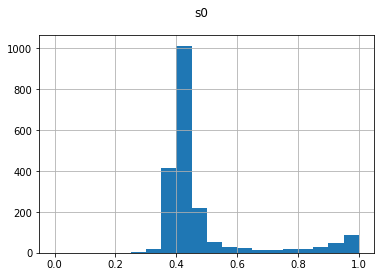

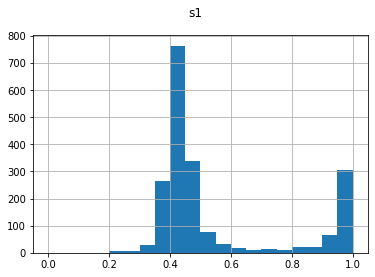

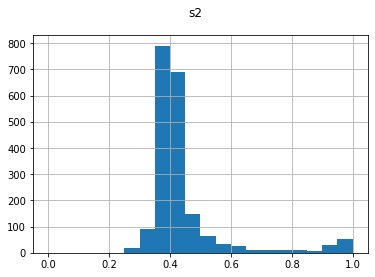

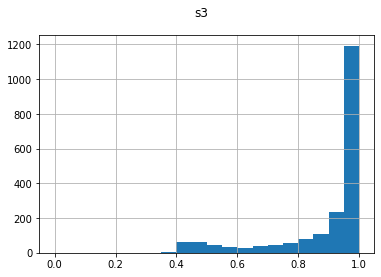

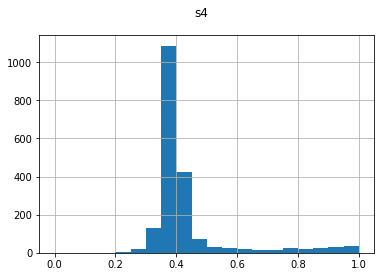

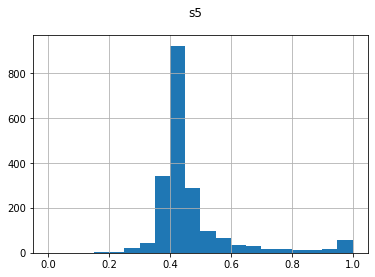

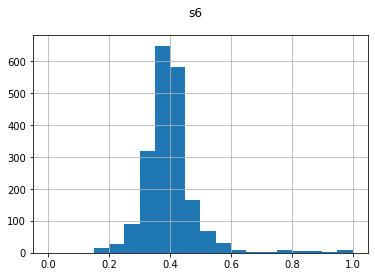

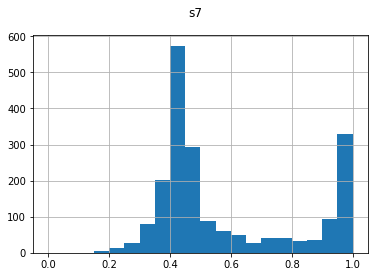

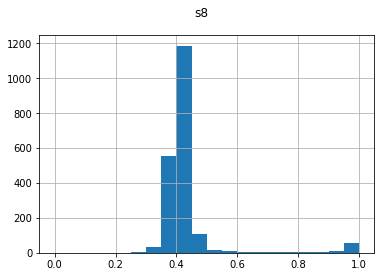

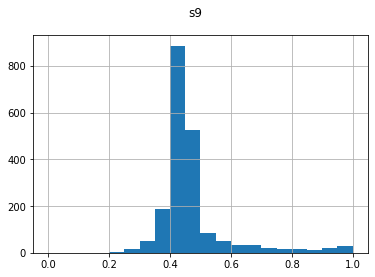

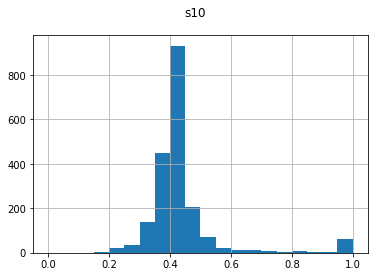

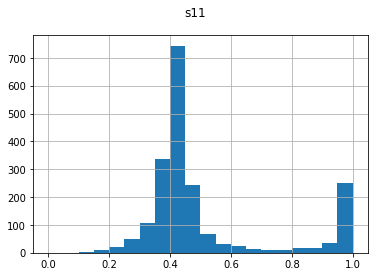

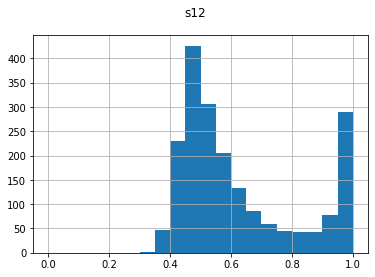

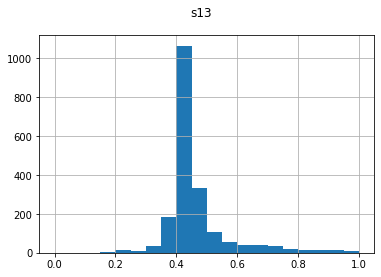

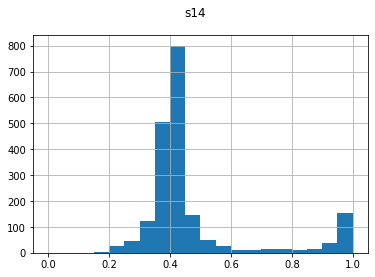

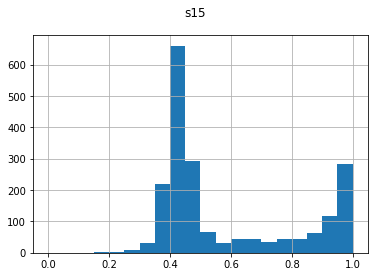

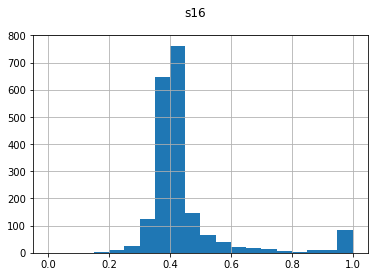

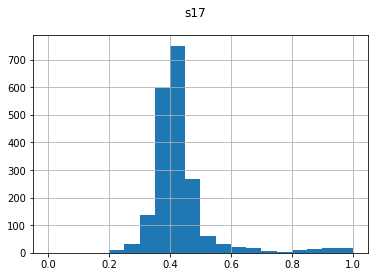

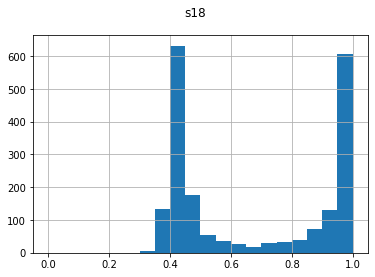

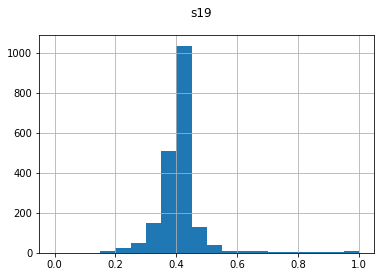

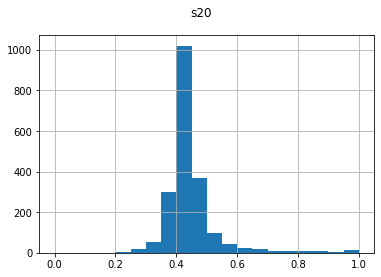

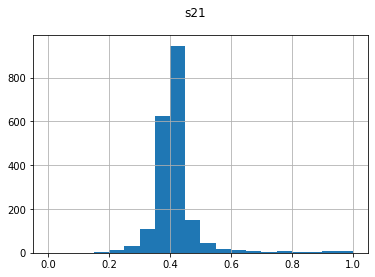

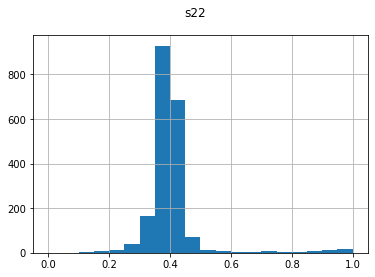

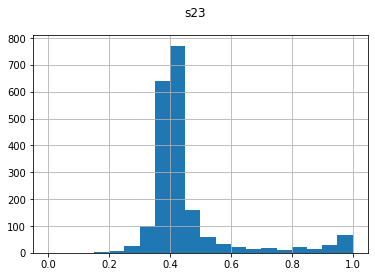

In [ ]:
for i in range(24):
  rank[f's{i}'].hist(bins=20,range=(0, 1)); # 基数の数を20個にする  

  plt.savefig("age_bins.png")


  plt.suptitle(f's{i}')
  plt.show()
  